# SNR Grid Calculations Tutorial

Update Summary

In load_inputs.py:

Added function for dynamic instrument contrast

Added off-axis mode imaging.

Added function to get planetary spectra

In noise_tools.py:

Fixed bugs with instrumental noise and sky noise (added exposure time), added coupling term for noise calculation throughput

In objects.py:

Added class on coronagraphs as well as planetary data

In plot.tools.py:

Added function for plotting signal and noise in on-axis mode

Added function to plot signal and noise , and SNR in off-axis mode

Added function to plot instrument contrast

Added a function to plot sky noise and instrumental noise.

All updates are bracketed by "####" and descriptions are written for each update

## MODHIS

In [1]:
# import some general packages
import sys,os
import matplotlib
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
from matplotlib.colors import LogNorm
from datetime import date
from astropy import units as u
# make plot fonts big
font = {'size'   : 14}
matplotlib.rc('font', **font)

# Load path to package and load a few useful things
sys.path.append('/Users/huihaoz/specsim/utils/')
from objects import load_object
from load_inputs import fill_data
from functions import *
import plot_tools,obs_tools



In [2]:
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt, correlate
import warnings
import pandas as pd

import wfe_tools
import throughput_tools
import load_inputs
import warnings
import rv_precision


## Loading Config File & Running an Observation

### Background
Key parameters are stored in the configuration file "hispec.cfg". The function "load_object" loads the contents of this configuration file into a storage object "so'. The objects.py function is a useful reference for seeing what is contained in so, but it has class attributes like 'stel' for stellar properties and 'track' for tracking camera properties. For example, the stellar temperature defined in the config file will be loaded and stored in "so.stel.teff".

The "fill_data" class takes the storage object and upon initiation, it fills the so object by running a bunch of things. As such, this process takes a little while - first it defines the wavelength grid (x) and yJHK filter bounds, then does the dirty work of loading, reinterpolating files, and calculating things in the following order:

**filter**
    (loads zeropoint and filter transmission curve for the band selected)

**stellar** 
    (loads the stellar spectrum based on the temperature chosen and scales it to the magnitude requested in the filter band set in the filter attribute of so)

**telluric**
    (loads the telluric spectrum and scales to the requested PWV and airmass)

**ao**
    (by default takes the magnitude of the star and uses input files to determine the expected WFE based on the AO mode selected which should match headers in the file. Or one can just set the params to some WFE)

**instrument**
    (loads the instrument transmission file if there is one, otherwise does HISPEC/MODHIS specific things and loads the base throughput and finds the coupling based on the WFE found previously assuming a specific file format)

**observe** 
    (takes all the loaded files to find the spectral flux at the instruments and degrades and resamples the spectrum according to the resolution and pixels provided. It also loads the background spectrum and noise to get the SNR per pixel and per resolution element)

**tracking** 
    (loads the tracking camera properties for the camera specified, loads the transmission file, interpolates, calculates the platescale, makes the tracking band transmission file, computs the PSF FWHM and the strehl, determines the sky and instrument background, computes the photons at the tracking camera, combines the noise, gives the SNR and expected centroid error
    
There are some other functions in the load_objects.py that can be used to reload a subset of things and are useful since there are a lot of orders of operations. These are still kinda confusing but I will demonstrate how I use them to cycle over a lot of parameters

## The Code - Running A Single Instance
Here is the code to load a config file and run it

In [3]:
configfile = '/Users/huihaoz/specsim/examples/modhis.cfg' # define our config file name and path

In [4]:
so    = load_object(configfile)     # Load the contents of the config file into the so "storage object"

In [5]:
str(so.tel.zenith)

'30.0'

In [6]:
cload = fill_data(so)               # Initiate the fill_data class which runs an observation and stores the results in so

------FILLING OBJECT--------
Planet Teff set to 700.0
Planet K band mag set to 19.0
Star Teff set to 2800.0
Star K band mag set to 14.0
auto ao mode
ao mode: LGS_ON R
tt: 3.3242972784154494
ho: 155.4
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:201: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(flux + total_bg + npix * sig_read**2 + darknoise * npix * texp)


Tracking FWHM=3.801899640113331pix
Tracking photons: 207316.72652605458 e-
Tracking noise: 457.2269881996317 e-
dynamic instrument contrast ready
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:249: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:253: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)


direct imaging ready
ETC for off-axis mode ready
no ccf snr
no etc for ccf


/Users/huihaoz/specsim/utils/load_inputs.py:1152: UserWarning: This function is incomplete at the moment. Double check all results for accuracy.
  warnings.warn('This function is incomplete at the moment. Double check all results for accuracy.')
/Users/huihaoz/specsim/utils/load_inputs.py:520: RuntimeWarning: invalid value encountered in true_divide
  telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass
/Users/huihaoz/specsim/utils/load_inputs.py:562: RuntimeWarning: divide by zero encountered in double_scalars
  dv_order  = SPEEDOFLIGHT / (np.nansum(w_ord[1:-1])**0.5) # m/s


In [ ]:
np.mean(so.rv.telluric_mask)

0.40064829642515565

In [34]:
np.mean(so.rv.s_tel)

0.62505017914209

In [30]:
np.min(so.rv.dv_vals)

1.211581767319509

In [12]:
print(np.mean(so.rv.all_w))
print(np.mean(so.rv.s_tel))
print(np.mean(so.rv.telluric_mask))
print(np.mean(so.rv.order_cen_lam))
print(np.mean(so.rv.order_indices))

3300448393548.808
0.62505017914209
0.40064829642515565
1643.0931864136476


/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (3023,) (3103,) 

In [13]:
print(np.mean(so.tel.rayleigh))
print(so.rv.order_indices)

0.8590514806180566
[array([229764, 229765, 229766, ..., 232784, 232785, 232786]), array([234098, 234099, 234100, ..., 237198, 237199, 237200]), array([238673, 238674, 238675, ..., 241860, 241861, 241862]), array([243338, 243339, 243340, ..., 246615, 246616, 246617]), array([248034, 248035, 248036, ..., 251402, 251403, 251404]), array([252784, 252785, 252786, ..., 255754, 255755, 255756]), array([257121, 257122, 257123, ..., 260177, 260178, 260179]), array([261590, 261591, 261592, ..., 264737, 264738, 264739]), array([266264, 266265, 266266, ..., 269507, 269508, 269509]), array([270900, 270901, 270902, ..., 274240, 274241, 274242]), array([275863, 275864, 275865, ..., 279308, 279309, 279310]), array([280862, 280863, 280864, ..., 284415, 284416, 284417]), array([286088, 286089, 286090, ..., 289756, 289757, 289758]), array([291468, 291469, 291470, ..., 295165, 295166, 295167]), array([296621, 296622, 296623, ..., 300042, 300043, 300044]), array([301733, 301734, 301735, ..., 305272, 305273

In [14]:
def degrade_spec(x,y,res):
    """
    given wavelength, flux array, and resolving power R, return  spectrum at that R
    """
    lsf      = define_lsf(x,res=res)
    y_lowres = np.convolve(y,lsf,mode='same')

    return y_lowres

In [68]:

"""
"""
cutoff=0.01 ###hard
velocity_cutoff=int(10) ###hard
water_only='False' ###hard
telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass
if water_only: telluric_spec = np.abs(so.tel.h2o)**so.tel.airmass #h2o only
telluric_spec[np.where(np.isnan(telluric_spec))] = 0
telluric_spec_lores = degrade_spec(so.stel.v, telluric_spec, so.inst.res)
# resample onto v array
filt_interp	 = interpolate.interp1d(so.stel.v, telluric_spec_lores, bounds_error=False,fill_value=0)
s_tel		 = filt_interp(so.obs.v)/np.max(filt_interp(so.obs.v))	# filter profile resampled to phoenix times phoenix flux density

#cutoff = 0.01 # reject lines greater than 1% depth
telluric_mask = np.ones_like(s_tel)
telluric_mask[np.where(s_tel < (1-cutoff))[0]] = 0
# avoid +/-5km/s  (5pix) around telluric
for iroll in range(velocity_cutoff):
    telluric_mask[np.where(np.roll(s_tel,iroll) < (1-cutoff))[0]] = 0
    telluric_mask[np.where(np.roll(s_tel,-1*iroll) < (1-cutoff))[0]] = 0

rv_telluric_mask=telluric_mask
rv_s_tel=s_tel

/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_1953/1941133572.py:6: RuntimeWarning: invalid value encountered in true_divide
  telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass


In [67]:
water_only

False

In [70]:

cutoff=so.rv.cutoff
velocity_cutoff=int(so.rv.velocity_cutoff)
water_only=False
telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass
if water_only: telluric_spec = np.abs(so.tel.h2o)**so.tel.airmass #h2o only
telluric_spec[np.where(np.isnan(telluric_spec))] = 0
telluric_spec_lores = degrade_spec(so.stel.v, telluric_spec, so.inst.res)
# resample onto v array
filt_interp	 = interpolate.interp1d(so.stel.v, telluric_spec_lores, bounds_error=False,fill_value=0)
s_tel		 = filt_interp(so.obs.v)/np.max(filt_interp(so.obs.v))	# filter profile resampled to phoenix times phoenix flux density

#cutoff = 0.01 # reject lines greater than 1% depth
telluric_mask = np.ones_like(s_tel)
telluric_mask[np.where(s_tel < (1-cutoff))[0]] = 0
# avoid +/-5km/s  (5pix) around telluric
for iroll in range(velocity_cutoff):
    telluric_mask[np.where(np.roll(s_tel,iroll) < (1-cutoff))[0]] = 0
    telluric_mask[np.where(np.roll(s_tel,-1*iroll) < (1-cutoff))[0]] = 0

rv_telluric_mask2=telluric_mask
rv_s_tel2=s_tel

/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_1953/1533186067.py:4: RuntimeWarning: invalid value encountered in true_divide
  telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass


In [71]:
water_only

False

In [72]:
print(np.mean(rv_telluric_mask2))
print(np.mean(rv_s_tel2))

0.25605128876095773
0.5980085190042809


In [73]:
print(np.mean(rv_telluric_mask))
print(np.mean(rv_s_tel))

0.40064829642515565
0.62505017914209


In [14]:
def get_sky_bg(x,airmass=1.5,pwv=1.5,npix=3,lam0=2000,R=100000,diam=10,area=76,skypath = '../../../../_DATA/sky/'):
    """
    generate sky background per reduced pixel, default to HIPSEC. Source: DMawet jup. notebook

    inputs:
    -------

    outputs:
    --------
    sky background (ph/s)
    """
    diam *= u.m
    area = area * u.m * u.m
    wave=x*u.nm

    fwhm = ((wave  / diam) * u.radian).to(u.arcsec)
    solidangle = fwhm**2 * 1.13 #corrected for Gaussian beam (factor 1.13)

    sky_background_MK_tmp  = np.genfromtxt(skypath+'mk_skybg_zm_'+str(pwv)+'_'+str(airmass)+'_ph.dat', skip_header=0)
    sky_background_MK      = sky_background_MK_tmp[:,1]
    sky_background_MK_wave = sky_background_MK_tmp[:,0] #* u.nm

    pix_width_nm  = (wave/R/npix) #* u.nm 
    sky_background_interp=np.interp(wave.value, sky_background_MK_wave, sky_background_MK) * u.photon/(u.s*u.arcsec**2*u.nm*u.m**2) * area * solidangle * pix_width_nm 

    return sky_background_interp.value # ph/s

0.7091417635386232

In [47]:
diam = 10 *  u.m
area = 76 * u.m * u.m
wave = so.obs.v * u.nm
fwhm = (((wave / diam)) * u.radian ).to(u.arcsec)
R = 100000
npix = 3
solidangle = fwhm**2 * 1.13
sky_background_MK_tmp  = np.genfromtxt('/Users/huihaoz/specsim/_Data/sky/'+'mk_skybg_zm_'+str(1.5)+'_'+str(1.2)+'_ph.dat', skip_header=0)
sky_background_MK      = sky_background_MK_tmp[:,1]
sky_background_MK_wave = sky_background_MK_tmp[:,0] #* u.nm

pix_width_nm  = (wave/R/npix) #* u.nm 
sky_background_interp=np.interp(wave.value, sky_background_MK_wave, sky_background_MK) * u.photon/(u.s*u.arcsec**2*u.nm*u.m**2) * area * solidangle * pix_width_nm 
print(np.max(sky_background_interp))
print(np.mean(sky_background_interp))


5.867917505652767 ph / s
0.03087526142067076 ph / s


In [19]:
print(so.tel.s)
print(so.stel.v)
print(so.obs.v)
print(so.inst.res)
print(np.mean(so.tel.s))
print(np.mean(so.stel.v))
print(np.mean(so.obs.v))
print(np.mean(so.inst.res))
print(np.min(so.tel.s))
print(np.min(so.stel.v))
print(np.min(so.obs.v))
print(np.min(so.inst.res))
#    print(np.mean(so.rv_all_w))
print(np.mean(so.rv.s_tel))
print(np.mean(so.rv.telluric_mask))

[0.         0.         0.         ... 0.21529918 0.21524125 0.21496501]
[ 500.          500.0005      500.001      ... 2649.99849995 2649.99899995
 2649.99949995]
[ 500.          500.0015      500.003      ... 2649.97699995 2649.98549995
 2649.99399995]
100000.0
0.7091417635386232
1574.9997499745728
1266.1403401652044
100000.0
-1.1410370566997429e-07
500.0
500.0
100000.0
0.62505017914209
0.40064829642515565


In [29]:
so.obs.v

array([ 500.        ,  500.0015    ,  500.003     , ..., 2649.97699995,
       2649.98549995, 2649.99399995])

In [48]:
so.obs.sky_bg_ph_test = noise_tools.get_sky_bg(so.obs.v,so.tel.airmass,pwv=so.tel.pwv,skypath=so.tel.skypath)
so.inst.bg_ph_test = noise_tools.get_inst_bg(so.obs.v,npix=so.inst.pix_vert,R=so.inst.res,diam=so.inst.tel_diam,area=so.inst.tel_area,datapath=so.inst.transmission_path)

In [52]:
em_red,em_blue, temps = throughput_tools.get_emissivity(so.obs.v,datapath='/Users/huihaoz/specsim/_Data/Throughput/')


In [56]:
"""
generate sky background per reduced pixel, default to HIPSEC. Source: DMawet jup. notebook

inputs:
-------

outputs:
--------
sky background (photons/s) already considering PSF sampling

"""
em_red,em_blue, temps = throughput_tools.get_emissivity(so.obs.v,datapath='/Users/huihaoz/specsim/_Data/Throughput/')

# telescope
diam = so.inst.tel_diam*u.m
area =so.inst.tel_area* u.m * u.m
wave = so.obs.v * u.nm

fwhm = ((wave  / diam) * u.radian).to(u.arcsec)
solidangle = fwhm**2 * 1.13 #corrected for Gaussian beam (factor 1.13)
pix_width_nm  = (wave/R/npix) #* u.nm 

# step through temperatures and emissivities for red and blue
# red
for i,temp in enumerate(temps):
    bbtemp_fxn  = BlackBody(temp * u.K, scale=1.0 * u.erg / (u.micron * u.s * u.cm**2 * u.arcsec**2)) 
    bbtemp = bbtemp_fxn(wave) *  area.to(u.cm**2) * solidangle
    #bbtemp = blackbody_lambda(wave, temp).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle
    if i==0:
        tel_thermal_red  = em_red[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
        tel_thermal_blue = em_blue[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
    else:
        therm_red_temp   = em_red[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
        therm_blue_temp  = em_blue[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
        tel_thermal_red+= therm_red_temp
        tel_thermal_blue+= therm_blue_temp

# interpolate and combine into one thermal spectrum
isubred = np.where(wave > 1.4*u.um)[0]
em_red_tot  = tel_thermal_red[isubred].decompose()
isubblue = np.where(wave <1.4*u.um)[0]
em_blue_tot  = tel_thermal_blue[isubblue].decompose()

w = np.concatenate([so.obs.v[isubblue],so.obs.v[isubred]])
s = np.concatenate([em_blue_tot,em_red_tot])

tck        = interpolate.splrep(w,s.value, k=2, s=0)
em_total   = interpolate.splev(so.obs.v,tck,der=0,ext=1)

print(em_total) # units of ph/s/pix


[8.64199531e-36 8.64467282e-36 8.64735113e-36 ... 8.87598445e+00
 8.87651606e+00 8.87704769e+00]


In [72]:
print('lenthermal_red',len(tel_thermal_red))
print('maxthermal_red:',np.max(tel_thermal_red))
print('meanthermal_red:',np.mean(tel_thermal_red))
print('lenthermal_red',len(tel_thermal_red))
print('maxthermal_red:',np.max(tel_thermal_blue))
print('meanthermal_red:',np.mean(tel_thermal_blue) )

lenthermal_red 542653
maxthermal_red: 8877.047688544038 nm ph / (micron s)
meanthermal_red: 207.5223834655052 nm ph / (micron s)
lenthermal_red 542653
maxthermal_red: 8877.047688544038 nm ph / (micron s)
meanthermal_red: 219.66229165362415 nm ph / (micron s)


In [92]:
noise_frame = noise_tools.sum_total_noise(so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert)
#noise_frame[np.where(np.isnan(noise_frame))] = np.inf
#noise_frame[np.where(noise_frame==0)] = np.inf

/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)


In [93]:
noise_frame

array([ 7.34846923,  7.34846923,  7.34846923, ..., 89.67935105,
       89.68201854, 89.68468609])

In [91]:
np.mean(noise_frame)

inf

In [69]:
print('meantemps',np.mean(temps))
print('maxtemps',np.max(temps))
print('lentemps',len(temps))

meantemps 242.83333333333334
maxtemps 276
lentemps 6


In [65]:
print('fwhmmax:',np.max(fwhm ))
print('fwhmmeam:',np.mean(fwhm) )
print('pix_widthmax:',np.max(pix_width_nm))
print('pix_widthmeam:',np.mean(pix_width_nm) )
print('m_red:',np.max(em_red ))
print('m_red:',np.mean(em_red) )
print('em_blue:',np.max( em_blue))
print('em_blue:',np.mean(em_blue) )
print('isubred:',np.max(isubred))
print('isubred:',np.mean(isubred) )
print('em_red_tot:',np.max(em_red_tot))
print('em_red_tot:',np.mean(em_red_tot) )
print('isubblue:',np.max(isubblue))
print('isubblue:',np.mean(isubblue) )
print('ek_bluetot:',np.max(em_blue_tot))
print('ek_bluetot:',np.mean(em_blue_tot) )

fwhmmax: 0.018220016631849377 arcsec
fwhmmeam: 0.008705339731526955 arcsec
pix_widthmax: 0.008833313333163865 nm
pix_widthmeam: 0.0042204678005506825 nm
m_red: 1.0
m_red: 0.5979400286055965
em_blue: 1.0
em_blue: 0.5964994833067794
isubred: 542652
isubred: 442894.5
em_red_tot: 8.877047688544039 ph / s
em_red_tot: 0.5644291325512567 ph / s
isubblue: 343136
isubblue: 171568.0
ek_bluetot: 6.468779558544367e-08 ph / s
ek_bluetot: 1.580700357756542e-09 ph / s


In [64]:
np.mean(temps)

242.83333333333334

In [ ]:
np.savetxt('stelraw',np.hstack((so.stel.vraw.reshape(-1,1),so.stel.sraw.reshape(-1,1))))

In [16]:
so.obs.v.reshape(-1,1)
np.savetxt('stelov',so.obs.v.reshape(-1,1))

In [26]:
so.stel.v.reshape(-1,1)
np.savetxt('stelrv',so.stel.v.reshape(-1,1))

In [25]:
np.hstack((so.stel.vraw.reshape(-1,1),so.stel.sraw.reshape(-1,1),so.stel.v.reshape(-1,1)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1053666 and the array at index 2 has size 4300000

In [27]:
np.mean(so.inst.ytransmit)

0.026341586555243383

In [29]:
np.max(so.inst.ytransmit)

0.07150935830921155

In [ ]:
so.stel.sraw.reshape(-1,1)

array([[8.8701264e+18],
       [9.6527852e+18],
       [3.0288157e+19],
       ...,
       [5.9568358e+21],
       [5.4545859e+21],
       [4.9628728e+21]], dtype=float32)

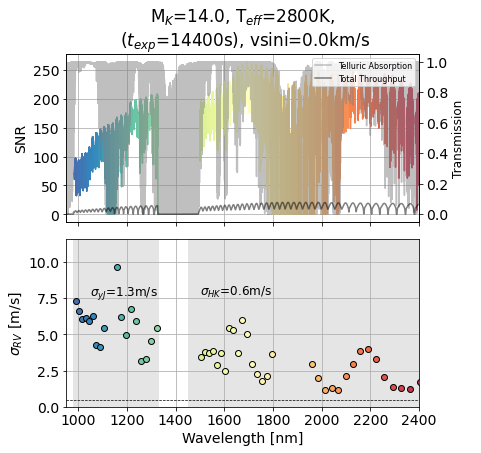

In [ ]:
plot_tools.plot_rv_err(so,savefig=False)

In [ ]:
#so.ao.tt_dynamic
#so.ao.ho_wfe
#so.ao.ho_wfe_mag
#so.ao.ho_wfe_band
#so.ao.ttdynamic_mag
#so.ao.ttdynamic_band

# RV pre

big question: for on-axis or off-axis?

In [ ]:
water_only=False;line_spacing=None; peak_spacing=2e4;height=0.055

In [ ]:
# calc signal to noise
import sys,os
import matplotlib
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate
import pandas as pd
from matplotlib.colors import LogNorm
from datetime import date

font = {'size'   : 14}
matplotlib.rc('font', **font)

sys.path.append('/Users/ashbake/Documents/Research/ToolBox/specsim/utils/')
from objects import load_object
from load_inputs import fill_data, load_filter,get_band_mag
from functions import *
from noise_tools import get_sky_bg, get_inst_bg, sum_total_noise
from throughput_tools import pick_coupling, get_base_throughput
from wfe_tools import get_tip_tilt_resid, get_HO_WFE
import plot_tools,obs_tools

def get_order_bounds(so,line_spacing=0.02,peak_spacing=1e3,height=0.055):
	"""
	given array, return max and mean of snr per order
	"""
	order_peaks	  = signal.find_peaks(so.inst.base_throughput,height=height,distance=peak_spacing,prominence=0.01)
	order_cen_lam	= so.stel.v[order_peaks[0]]
	blaze_angle	  =  76
	order_indices	=[]
	for i,lam_cen in enumerate(order_cen_lam):
		if line_spacing == None: line_spacing_now = 0.02 if lam_cen < 1475 else 0.01
		else: line_spacing_now=line_spacing
		m = np.sin(blaze_angle*np.pi/180) * 2 * (1/line_spacing_now)/(lam_cen/1000)
		fsr  = lam_cen/m
		isub_test= np.where((so.stel.v> (lam_cen - fsr/2)) & (so.stel.v < (lam_cen+fsr/2))) #FINISH THIS
		#plt.plot(so.stel.v[isub_test],so.inst.ytransmit[isub_test],'k--')
		order_indices.append(np.where((so.obs.v > (lam_cen - 0.9*fsr/2)) & (so.obs.v  < (lam_cen+0.9*fsr/2)))[0])

	return order_cen_lam,order_indices


def make_telluric_mask(so,cutoff=0.01,velocity_cutoff=5,water_only=False):
	"""
	"""
	telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass
	if water_only: telluric_spec = np.abs(so.tel.h2o)**so.tel.airmass #h2o only
	telluric_spec[np.where(np.isnan(telluric_spec))] = 0
	telluric_spec_lores = degrade_spec(so.stel.v, telluric_spec, so.inst.res)
	# resample onto v array
	filt_interp	 = interpolate.interp1d(so.stel.v, telluric_spec_lores, bounds_error=False,fill_value=0)
	s_tel		 = filt_interp(so.obs.v)/np.max(filt_interp(so.obs.v))	# filter profile resampled to phoenix times phoenix flux density

	#cutoff = 0.01 # reject lines greater than 1% depth
	telluric_mask = np.ones_like(s_tel)
	telluric_mask[np.where(s_tel < (1-cutoff))[0]] = 0
	# avoid +/-5km/s  (5pix) around telluric
	for iroll in range(velocity_cutoff):
		telluric_mask[np.where(np.roll(s_tel,iroll) < (1-cutoff))[0]] = 0
		telluric_mask[np.where(np.roll(s_tel,-1*iroll) < (1-cutoff))[0]] = 0

	return telluric_mask,s_tel


#V:wavelength, S:signal, N:noise?
def get_rv_content(v,s,n):
	"""
	"""
	flux_interp = interpolate.InterpolatedUnivariateSpline(v,s, k=1)
	dflux = flux_interp.derivative()
	spec_deriv = dflux(v)
	sigma_ord = np.abs(n) #np.abs(s) ** 0.5 # np.abs(n)
	sigma_ord[np.where(sigma_ord ==0)] = 1e10
	all_w = (v ** 2.) * (spec_deriv ** 2.) / sigma_ord ** 2. # include read noise and dark here!!
	
	return all_w

def get_rv_precision(all_w,order_cens,order_inds,noise_floor=0.5,mask=None):
	if np.any(mask==None):
		mask = np.ones_like(all_w)
	dv_vals = np.zeros_like(order_cens)
	for i,lam_cen in enumerate(order_cens):
		w_ord = all_w[order_inds[i]] * mask[order_inds[i]]
		dv_order  = SPEEDOFLIGHT / (np.nansum(w_ord[1:-1])**0.5) # m/s
		dv_vals[i]  = dv_order
	
	dv_tot  = np.sqrt(dv_vals**2 + noise_floor**2)
	dv_spec  = 1. / (np.nansum(1./dv_vals**2.))**0.5
	dv_spec_floor  = 1. / (np.nansum(1./dv_tot**2.))**0.5

	return dv_tot,dv_spec,dv_vals


def plot_rv_err(so, lam_cen, dv_vals,savefig=True):
	"""
	"""
	col_table = plt.get_cmap('Spectral_r')
	fig, axs = plt.subplots(2,figsize=(7,7),sharex=True)
	plt.subplots_adjust(bottom=0.15,hspace=0.1,left=0.15,right=0.85,top=0.85)

	axs[1].plot([950,2400],[0.5,0.5],'k--',lw=0.7)
	axs[1].fill_between([1450,2400],0,1000,facecolor='gray',alpha=0.2)
	axs[1].fill_between([980,1330],0,1000,facecolor='gray',alpha=0.2)
	axs[1].grid('True')
	axs[1].set_ylim(-0,3*np.median(dv_vals))
	axs[1].set_xlim(950,2400)
	axs[1].set_ylabel('$\sigma_{RV}$ [m/s]')
	axs[1].set_xlabel('Wavelength [nm]')

	axs[0].set_ylabel('SNR')
	axs[0].set_title('M$_%s$=%s, T$_{eff}$=%sK,\n ($t_{exp}$=%ss), vsini=%skm/s'%(so.filt.band,so.stel.mag,int(so.stel.teff),int(so.obs.texp),so.stel.vsini))

	axs[0].grid('True')
	ax2 = axs[0].twinx() 
	ax2.plot(so.tel.v,so.tel.s,'gray',alpha=0.5,zorder=-100,label='Telluric Absorption')
	ax2.plot(so.stel.v,so.inst.ytransmit,'k',alpha=0.5,zorder=-100,label='Total Throughput')
	ax2.set_ylabel('Transmission',fontsize=12)
	for i,lam_cen in enumerate(order_cens):
		wvl_norm = (lam_cen - 900.) / (2500. - 900.)
		axs[0].plot(so.obs.v[order_inds[i]],so.obs.s[order_inds[i]]/so.obs.noise[order_inds[i]],zorder=200,color=col_table(wvl_norm))
		axs[1].plot(lam_cen,dv_vals[i],'o',zorder=100,color=col_table(wvl_norm),markeredgecolor='k')
	
	sub_yj = dv_vals[np.where((dv_vals!=np.inf) & (order_cens < 1400))[0]]
	sub_hk = dv_vals[np.where((dv_vals!=np.inf) & (order_cens > 1400))[0]]
	rvmed_yj = np.sqrt(np.sum(dv_vals[np.where((dv_vals!=np.inf) & (order_cens < 1400))[0]]**2))/np.sum(sub_yj)
	rvmed_hk = np.median(dv_vals[np.where((dv_vals!=np.inf) & (order_cens > 1400))[0]])
	dv_yj = 1. / (np.nansum(1./sub_yj**2.))**0.5	# 
	dv_hk = 1. / (np.nansum(1./sub_hk**2.))**0.5	# 
	dv_yj_tot = (so.inst.rv_floor**2 +dv_yj**2.)**0.5	# 
	dv_hk_tot = (so.inst.rv_floor**2 +dv_hk**2.)**0.5	# # 

	axs[1].text(1050,2*np.median(dv_vals),'$\sigma_{yJ}$=%sm/s'%round(dv_yj_tot,1),fontsize=12,zorder=101)
	axs[1].text(1500,2*np.median(dv_vals),'$\sigma_{HK}$=%sm/s'%round(dv_hk_tot,1),fontsize=12,zorder=101)
	ax2.legend(fontsize=8,loc=1)
	if savefig:
		plt.savefig('./output/rv_precision/RV_precision_%sK_%smag%s_%ss_vsini%skms.png'%(so.stel.teff,so.filt.band,so.stel.mag,so.obs.texp,so.stel.vsini))

	return fig,axs

if __name__=='__main__':
	SPEEDOFLIGHT = 2.998e8 # m/s
	GAUSSCONST = (2. * (2. * np.log(2))**0.5)

	#load inputs
#	configfile = './hispec_snr.cfg'
	so    = load_object(configfile)
	cload = fill_data(so) # put coupling files in load and wfe stuff too

	#plot_tools.plot_snr_orders(so,snrtype=1,mode='peak',savepath='./output/')

	# RV
	so.inst.rv_floor=0.5
	water_only=False;line_spacing=None; peak_spacing=2e4;height=0.055
	order_cens, order_inds  = get_order_bounds(so,line_spacing=line_spacing,peak_spacing=peak_spacing,height=height) # None and 2e4 for hispec
	telluric_mask,s_tel     = make_telluric_mask(so,cutoff=0.01,velocity_cutoff=10,water_only=water_only)
	all_w				    = get_rv_content(so.obs.v,so.obs.s,so.obs.noise)
	dv_tot,dv_spec,dv_vals	= get_rv_precision(all_w,order_cens,order_inds,noise_floor=so.inst.rv_floor,mask=telluric_mask)

	#fig,axs = plot_rv_err_agnostic(so, order_cens, dv_vals, savefig=False)
#	fig,axs = plot_rv_err(so, order_cens, dv_vals, savefig=False)


	### so.inst.rv_floor

------FILLING OBJECT--------
Planet Teff set to 700.0
Planet K band mag set to 19.0
Star Teff set to 2800.0
Star K band mag set to 14.0
auto ao mode
ao mode: LGS_ON V
tt: 2.09
ho: 204.0
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:192: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:196: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)
/usr/local/anaconda3/envs/surf_caltech/lib/python3.9/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


Tracking FWHM=3.6743208654820827pix
Tracking photons: 146735.12000781257 e-
Tracking noise: 385.17542539362944 e-
dynamic instrument contrast ready
Texp per frame set to 900.0
Nframes set to 16


/Users/huihaoz/specsim/utils/noise_tools.py:252: RuntimeWarning: invalid value encountered in sqrt
  sig_flux = np.sqrt(flux)
/Users/huihaoz/specsim/utils/noise_tools.py:256: RuntimeWarning: invalid value encountered in sqrt
  sig_bg   = np.sqrt(total_bg)


direct imaging ready
ETC for off-axis mode ready
no ccf snr
no etc for ccf


/Users/huihaoz/specsim/utils/load_inputs.py:1121: UserWarning: This function is incomplete at the moment. Double check all results for accuracy.
  warnings.warn('This function is incomplete at the moment. Double check all results for accuracy.')
/Users/huihaoz/specsim/utils/load_inputs.py:514: RuntimeWarning: invalid value encountered in true_divide
  telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass
/Users/huihaoz/specsim/utils/load_inputs.py:556: RuntimeWarning: divide by zero encountered in double_scalars
  dv_order  = SPEEDOFLIGHT / (np.nansum(w_ord[1:-1])**0.5) # m/s
/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_3048/1743774589.py:46: RuntimeWarning: invalid value encountered in true_divide
  telluric_spec = np.abs(so.tel.s/so.tel.rayleigh)**so.tel.airmass
/var/folders/6t/cpjtlkn10wv603vnph9nr3sh0000gn/T/ipykernel_3048/1743774589.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  dv_order  = SPEEDOFLIGHT / (np.nansum(w_ord[1:-1])**0.5

In [14]:
np.array(so.obs.v).reshape(-1.1)

TypeError: 'float' object cannot be interpreted as an integer

# code

In [ ]:
def filter(self,so):
    """
    load band for scaling stellar spectrum
    """
    # read zeropoint file, get zp
    zps                     = np.loadtxt(so.filt.zp_file,dtype=str).T
    izp                     = np.where((zps[0]==so.filt.family) & (zps[1]==so.filt.band))[0]
    so.filt.zp              = float(zps[2][izp])

    # find filter file and load filter
    so.filt.filter_file         = glob.glob(so.filt.filter_path + '*' + so.filt.family + '*' +so.filt.band + '.dat')[0]
    so.filt.xraw, so.filt.yraw  = np.loadtxt(so.filt.filter_file).T # nm, transmission out of 1
    if np.max(so.filt.xraw)>5000: so.filt.xraw /= 10
    if np.max(so.filt.xraw) < 10: so.filt.xraw *= 1000
    
    f                       = interpolate.interp1d(so.filt.xraw, so.filt.yraw, bounds_error=False,fill_value=0)
    so.filt.v, so.filt.s    = self.x, f(self.x)  #filter profile sampled at stellar

    so.filt.dl_l                 = np.mean(integrate(so.filt.xraw, so.filt.yraw)/so.filt.xraw) # dlambda/lambda
    so.filt.center_wavelength    = integrate(so.filt.xraw,so.filt.yraw*so.filt.xraw)/integrate(so.filt.xraw,so.filt.yraw)

In [ ]:
def calc_nphot(dl_l, zp, mag):
	"""
	http://astroweb.case.edu/ssm/ASTR620/mags.html

	Values are all for a specific bandpass, can refer to table at link ^ for values
	for some bands. Function will return the photons per second per meter squared
	at the top of Earth atmosphere for an object of specified magnitude

	inputs:
	-------
	dl_l: float, delta lambda over lambda for the passband
	zp: float, flux at m=0 in Jansky
	mag: stellar magnitude

	outputs:
	--------
	photon flux
	"""
	phot_per_s_m2_per_Jy = 1.51*10**7 # convert to phot/s/m2 from Jansky

	return dl_l * zp * 10**(-0.4*mag) * phot_per_s_m2_per_Jy
def integrate(x,y):
    """
    Integrate y wrt x
    """
    return trapz(y,x=x)

In [ ]:
def load_phoenix(stelname,wav_start=750,wav_end=780):
	"""
	load fits file stelname with stellar spectrum from phoenix 
	http://phoenix.astro.physik.uni-goettingen.de/?page_id=15
	
	return subarray 
	
	wav_start, wav_end specified in nm
	
	convert s from egs/s/cm2/cm to phot/cm2/s/nm using
	https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf
	"""
	
	# conversion factor

	f = fits.open(stelname)
	spec = f[0].data / (1e8) # ergs/s/cm2/cm to ergs/s/cm2/Angstrom for conversion
	f.close()
	
	path = stelname.split('/')
	wave_file = '/' + os.path.join(*stelname.split('/')[0:-1]) + '/' + \
					'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' #assume wave in same folder
	f = fits.open(wave_file)
	lam = f[0].data # angstroms
	f.close()
	
	# Convert
	conversion_factor = 5.03*10**7 * lam #lam in angstrom here
	spec *= conversion_factor # phot/cm2/s/angstrom
	
	# Take subarray requested
	isub = np.where( (lam > wav_start*10.0) & (lam < wav_end*10.0))[0]

	# Convert 
	return lam[isub]/10.0,spec[isub] * 10 * 100**2 #nm, phot/m2/s/nm

In [ ]:
def load_sonora(stelname,wav_start=750,wav_end=780):
	"""
	load sonora model file
	
	return subarray 
	
	wav_start, wav_end specified in nm
	
	convert s from erg/cm2/s/Hz to phot/cm2/s/nm using
	https://hea-www.harvard.edu/~pgreen/figs/Conversions.pdf

	wavelenght loaded is microns high to low
	"""
	f = np.loadtxt(stelname,skiprows=2)

	lam  = 10000* f[:,0][::-1] #microns to angstroms, needed for conversiosn
	spec = f[:,1][::-1] # erg/cm2/s/Hz
	
	spec *= 3e18/(lam**2)# convert spec to erg/cm2/s/angstrom
	
	conversion_factor = 5.03*10**7 * lam #lam in angstrom here
	spec *= conversion_factor # phot/cm2/s/angstrom
	
	isub = np.where( (lam > wav_start*10.0) & (lam < wav_end*10.0))[0]

	return lam[isub]/10.0,spec[isub] * 10 * 100**2 #nm, phot/m2/s/nm (my fave)

In [ ]:
from scipy import interpolate
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy import signal
import numpy as np

#from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy import constants as c 

import matplotlib.pylab as plt
from astropy.io import fits
import sys,glob,os
import pandas as pd
from astropy.convolution import Gaussian1DKernel, convolve
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt, correlate
import warnings

import throughput_tools# import pick_coupling, get_band_mag, get_base_throughput,grid_interp_coupling
from wfe_tools import get_tip_tilt_resid, get_HO_WFE
import obs_tools
import noise_tools
import astropy.units as u
from functions import *
from astropy import constants as consts
from scipy.ndimage.interpolation import shift
import wfe_tools

In [ ]:
def scale_stellar(so, mag):
	"""
	scale spectrum by magnitude
	inputs: 
	so: object with all variables
	mag: magnitude in filter desired

	load new stellar to match bounds of filter since may not match working badnpass elsewhere
	"""
	if so.stel.model=='phoenix':
		stelv,stels       =  load_phoenix(so.stel.stel_file,wav_start=np.min(so.filt.xraw), wav_end=np.max(so.filt.xraw)) #phot/m2/s/nm
	elif so.stel.model=='sonora':
		stelv,stels       =  load_sonora(so.stel.stel_file,wav_start=np.min(so.filt.xraw), wav_end=np.max(so.filt.xraw)) #phot/m2/s/nm

	filt_interp       =  interpolate.interp1d(so.filt.xraw, so.filt.yraw, bounds_error=False,fill_value=0)

	filtered_stellar   = stels * filt_interp(stelv)    # filter profile resampled to phoenix times phoenix flux density
	nphot_expected_0   = calc_nphot(so.filt.dl_l, so.filt.zp, mag)    # what's the integrated flux supposed to be in photons/m2/s?
	nphot_phoenix      = integrate(stelv,filtered_stellar)            # what's the integrated flux now? in same units as ^
	
	return nphot_expected_0/nphot_phoenix

In [ ]:
def _lsf_rotate(deltav,vsini,epsilon=0.6):
    '''
    Computes vsini rotation kernel.
    Based on the IDL routine LSF_ROTATE.PRO

    Parameters
    ----------
    deltav : float
        Velocity sampling for kernel (x-axis) [km/s]

    vsini : float
        Stellar vsini value [km/s]

    epsilon : float
        Limb darkening value (default is 0.6)

    Returns
    -------
    kernel : array
        Computed kernel profile

    velgrid : float
        x-values for kernel [km/s]

    '''

    # component calculations
    ep1 = 2.0*(1.0 - epsilon)
    ep2 = np.pi*epsilon/2.0
    ep3 = np.pi*(1.0 - epsilon/3.0)

    # make x-axis
    npts = np.ceil(2*vsini/deltav)
    if npts % 2 == 0:
        npts += 1
    nwid = np.floor(npts/2)
    x_vals = (np.arange(npts) - nwid) * deltav/vsini
    xvals_abs = np.abs(1.0 - x_vals**2)
    velgrid = xvals_abs*vsini

    # compute kernel
    kernel = (ep1*np.sqrt(xvals_abs) + ep2*xvals_abs)/ep3

    return kernel, velgrid

In [ ]:
def planet(self,so):
	"""
	loads planet spectrum
	returns spectrum scaled to input V band mag 

	everything in nm

	date of the change: Jul 12, 2023

	Huihao Zhang (zhang.12043@osu.edu)

	"""
	# Part 1: load raw spectrum
	#
	print('Planet Teff set to %s'%so.plan.teff)
	print('Planet %s band mag set to %s'%(so.filt.band,so.plan.mag))

	if so.plan.teff < 2300: # sonora models arent sampled as well so use phoenix as low as can
		g    = '316' # mks units, np.log10(316 * 100)=4.5 to match what im holding for phoenix models.
		pteff = str(int(so.plan.teff))
		so.stel.model             = 'sonora'
		so.stel.stel_file         = so.stel.sonora_folder + 'sp_t%sg%snc_m0.0' %(pteff,g) ###ok
		so.plan.vraw,so.plan.sraw = load_sonora(so.stel.stel_file,wav_start=so.inst.l0,wav_end=so.inst.l1) ###ok, all in cfg.
	else:
		pteff = str(int(so.plan.teff)).zfill(5)
		so.stel.model             = 'phoenix' 
		so.stel.stel_file         = so.stel.phoenix_folder + 'lte%s-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'%(pteff)
		so.plan.vraw,so.plan.sraw = load_phoenix(so.stel.stel_file,wav_start=so.inst.l0, wav_end=so.inst.l1) #phot/m2/s/nm ###ok, all in cfg.
	
	so.plan.v   = self.x
	tck_plan   = interpolate.splrep(so.plan.vraw,so.plan.sraw, k=2, s=0)
	so.plan.s   = interpolate.splev(self.x,tck_plan,der=0,ext=1) ###ok

	# apply scaling factor to match filter zeropoint
	so.plan.factor_0   = scale_stellar(so, so.plan.mag)  ###ok
	so.plan.s   *= so.plan.factor_0
	so.plan.units = 'photons/s/m2/nm' # stellar spec is in photons/s/m2/nm ###ok

	# broaden star spectrum with rotation kernal
	if so.plan.vsini > 0:
		dwvl_mean = np.abs(np.nanmean(np.diff(self.x)))
		SPEEDOFLIGHT = 2.998e8 # m/s
		dvel_mean = (dwvl_mean / np.nanmean(self.x)) * SPEEDOFLIGHT / 1e3 # average sampling in km/s
		vsini_kernel,_ = _lsf_rotate(dvel_mean,so.plan.vsini,epsilon=0.6) ###ok
		flux_vsini     = convolve(so.plan.s,vsini_kernel,normalize_kernel=True)  # photons / second / Ang
		so.plan.s      = flux_vsini       
	##same thing as above?
	if so.plan.rv > 0:
		dvelocity =   (so.plan.v / 300000) * u.nm * consts.c / (so.plan.v * u.nm )
		rv_shift_resel = np.mean(so.plan.rv * u.km / u.s / dvelocity) * 1000*u.m/u.km
		spec_shifted = shift(so.plan.s,rv_shift_resel.value)
		so.plan.s      = spec_shifted 

In [ ]:
def stellar(self,so):
	"""
	loads stellar spectrum
	returns spectrum scaled to input V band mag 

	everything in nm
	"""
	# Part 1: load raw spectrum
	#
	print('Star Teff set to %s'%so.stel.teff)
	print('Star %s band mag set to %s'%(so.filt.band,so.stel.mag))

	if so.stel.teff < 2300: # sonora models arent sampled as well so use phoenix as low as can
		g    = '316' # mks units, np.log10(316 * 100)=4.5 to match what im holding for phoenix models.
		teff = str(int(so.stel.teff))
		so.stel.stel_file         = so.stel.sonora_folder + 'sp_t%sg%snc_m0.0' %(teff,g)
		so.stel.vraw,so.stel.sraw = load_sonora(so.stel.stel_file,wav_start=so.inst.l0,wav_end=so.inst.l1)
		so.stel.model             = 'sonora'
	else:
		teff = str(int(so.stel.teff)).zfill(5)
		so.stel.model             = 'phoenix' 
		so.stel.stel_file         = so.stel.phoenix_folder + 'lte%s-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'%(teff)
		so.stel.vraw,so.stel.sraw = load_phoenix(so.stel.stel_file,wav_start=so.inst.l0, wav_end=so.inst.l1) #phot/m2/s/nm
	
	so.stel.v   = self.x
	tck_stel    = interpolate.splrep(so.stel.vraw,so.stel.sraw, k=2, s=0)
	so.stel.s   = interpolate.splev(self.x,tck_stel,der=0,ext=1)

	# apply scaling factor to match filter zeropoint
	so.stel.factor_0   = scale_stellar(so, so.stel.mag) 
	so.stel.s   *= so.stel.factor_0
	so.stel.units = 'photons/s/m2/nm' # stellar spec is in photons/s/m2/nm

	# broaden star spectrum with rotation kernal
	if so.stel.vsini > 0:
		dwvl_mean = np.abs(np.nanmean(np.diff(self.x)))
		SPEEDOFLIGHT = 2.998e8 # m/s
		dvel_mean = (dwvl_mean / np.nanmean(self.x)) * SPEEDOFLIGHT / 1e3 # average sampling in km/s
		vsini_kernel,_ = _lsf_rotate(dvel_mean,so.stel.vsini,epsilon=0.6)
		flux_vsini     = convolve(so.stel.s,vsini_kernel,normalize_kernel=True)  # photons / second / Ang
		so.stel.s      = flux_vsini
	if so.stel.rv > 0:
		dvelocity =   (so.stel.v / 300000) * u.nm * consts.c / (so.stel.v * u.nm )
		rv_shift_resel = np.mean(so.stel.rv * u.km / u.s / dvelocity) * 1000*u.m/u.km
		spec_shifted = shift(so.stel.s,rv_shift_resel.value)
		so.stel.s      = spec_shifted

In [ ]:
def get_base_throughput(wave,ploton=False,datapath = './data/throughput/hispec_subsystems_11032022/'):
    """
    get throughput except leave out coupling

    also store emissivity
    """
    #plt.figure()
    for spec in ['red','blue']:
        if spec=='red':
            include = ['tel', 'ao', 'feicom', 'feired','fibred','rspec']#,'coupling']
        if spec=='blue':
            include = ['tel', 'ao', 'feicom', 'feiblue','fibblue','bspec']#,'coupling']

        for i in include:
            if i==include[0]:
                w,s = np.loadtxt(datapath + i + '/%s_throughput.csv'%i, delimiter=',',skiprows=1).T
                #plt.plot(w,s,label=i)
            else:
                wtemp, stemp = np.loadtxt(datapath + i + '/%s_throughput.csv'%i, delimiter=',',skiprows=1).T
                # interpolate onto s
                f = interpolate.interp1d(wtemp, stemp, bounds_error=False,fill_value=0)
                s*=f(w)
                #plt.plot(w,s,label=i)

        if spec=='red':
            isub = np.where(w > 1.4) 
            wred = w[isub]
            specred = s[isub]
        if spec=='blue':
            isub = np.where(w<1.4)
            specblue = s[isub]
            wblue = w[isub]
    
    w = np.concatenate([wblue,wred])
    s = np.concatenate([specblue,specred])

    # reinterpolate 
    x = wave.copy()
    if np.min(x) > 10:
        x/=1000 #convert nm to um

    tck    = interpolate.splrep(w,s, k=2, s=0)
    snew   = interpolate.splev(x,tck,der=0,ext=1)

    if ploton:
        plt.plot(wblue,specblue,label='blue')
        plt.plot(wred,specred,label='red')
        plt.grid(True)
        plt.xlabel('Wavelength (um)')
        plt.ylabel('Transmission')
        plt.title("Spectrograph Throughput Except Coupling")
        plt.savefig('base_throughput.png')

    return snew

In [ ]:
def grid_interp_coupling(PLon=1,path='/Users/ashbake/Documents/Research/Projects/HISPEC/SNR_calcs/data/throughput/hispec_subsystems_11032022/coupling/',atm=1,adc=1):
    """
    interpolate coupling files over their various parameters
    PLon: 0 or 1, whether PL is on or not
    path: data path to coupling files
    atm: 0 or 1 - whether gary at atm turned on in sims
    adc: 0 or 1 - whether gary had adc included in sims
    """
    LOs = np.arange(0,125,25)
    ttStatics = np.arange(11)
    ttDynamics = np.arange(0,20.5,0.5)
    
    filename_skeleton = 'couplingEff_atm%s_adc%s_PL%s_defoc25nmRMS_LO%snmRMS_ttStatic%smas_ttDynamic%smasRMS.csv'

    # to dfine values, must open up each file. not sure if can deal w/ wavelength
    values_1 = np.zeros((len(LOs),len(ttStatics),len(ttDynamics),100))
    values_2 = np.zeros((len(LOs),len(ttStatics),len(ttDynamics),100))
    values_3 = np.zeros((len(LOs),len(ttStatics),len(ttDynamics),100))  
    for i,LO in enumerate(LOs):
        for j,ttStatic in enumerate(ttStatics):
            for k,ttDynamic in enumerate(ttDynamics):
                if round(ttDynamic)==ttDynamic: ttDynamic=round(ttDynamic)
                f = pd.read_csv(path+filename_skeleton%(atm,adc,PLon,LO,ttStatic,ttDynamic))
                if PLon:
                    values_1[i,j,k,:]=f['coupling_eff_mode1'] #what to fill here?
                    values_2[i,j,k,:]=f['coupling_eff_mode2'] #what to fill here?
                    values_3[i,j,k,:]=f['coupling_eff_mode3'] #what to fill here?
                else:
                    values_1[i,j,k,:]=f['coupling_eff_mode1'] #what to fill here?

                #values_hk[i,j,k]=f['coupling_eff_mode1'][50] #what to fill here?
    
    points = (LOs, ttStatics, ttDynamics,f['wavelength_um'].values)

    if PLon:
        return points,values_1,values_2,values_3
    else:
        return points,values_1

In [ ]:
def calc_strehl(wfe,wavelength):
    """
    wfe: nm
    wavelength: nm
    """
    strehl = np.exp(-(2*np.pi*wfe/wavelength)**2)

    return strehl
def tt_to_strehl(tt,lam,D):
    """
    convert tip tilt residuals in mas to strehl according to Rich's equation
    
    equation 4.60 from Hardy 1998 (adaptive optics for astronomy) matches this

    lam: nm
        wavelength(s)
    D: m
        telescope diameter
    tt: mas
        tip tilt rms
    """
    tt_rad = tt * 1e-3/206265 # convert to radians from mas
    lam_m =lam * 1e-9
    bottom = 1 + np.pi**2/2*((tt_rad)/(lam_m/D))**2
    strehl_tt = 1/bottom

    #sig_D = 0.44* lam_m/D
    #1/(1 + tt_rad**2/sig_D**2) KAON1322 doc eq 5 method matches Richs eqn

    return strehl_tt
def setup_band(x, x0=0, sig=0.3, eta=1):
    """
    give step function

    inputs:
    ------
    x0
    sig
    eta
    """
    y = np.zeros_like(x)

    ifill = np.where((x > x0-sig/2) & (x < x0 + sig/2))[0]
    y[ifill] = eta

    return y

In [ ]:
def resample(x,y,sig=0.3, dx=0, eta=1,mode='variable'):
    """
    resample using convolution

    x: wavelength array in nm
    y_in/y_out: two y arrays (evaluated at x) to resample, units in spectral density (e.g. photons/nm)

    sig in nanometers - width of bin, default 0.3nm
    dx - offset for taking first bin, defaul 0
    eta 0-1 for efficiency (amplitude of bin) default 1
    
    modes: slow, fast
    slow more accurate (maybe?), fast uses fft

    slow method uses trapz so slightly more accurate, i think? both return similar flux values

    """
    if mode=='fast':
        dlam    = np.median(np.diff(x)) # nm per pixel, most accurate if x is uniformly sampled in wavelength
        if sig <= dlam: raise ValueError('Sigma value is smaller than the sampling of the provided wavelength array')
        nsamp   = int(sig / dlam)     # width of tophat
        tophat  = eta * np.ones(nsamp) # do i need to pad this?

        int_spec_oversample    = dlam * signal.fftconvolve(y,tophat,mode='same') # dlam integrating factor
        
        int_lam  = x[int(nsamp/2 + dx/dlam):][::nsamp] # shift over by dx/dlam (npoints) before taking every nsamp point
        int_spec =  int_spec_oversample[int(nsamp/2 + dx/dlam):][::nsamp]

    if mode=='variable':
        # mode to take variable res element
        dlam    = np.median(np.diff(x)) # nm per pixel, most accurate if x is uniformly sampled in wavelength
        if np.min(sig) <= dlam: raise ValueError('Sigma value is smaller than the sampling of the provided wavelength array')
        nsamp   = sig // dlam    # width of tophat
        nsamp = nsamp.astype('int')
        
        nsamp_unique = np.unique(nsamp)
        int_lam=np.array([])
        int_spec=np.array([])
        for n in nsamp_unique:
            isub = np.where(nsamp==n)[0]
            tophat  = eta * np.ones(n) # do i need to pad this?
            int_spec_oversample    = dlam * signal.fftconvolve(y[isub],tophat,mode='same') # dlam integrating factor
            xnew = x[isub][::n]
            ynew = int_spec_oversample[::n]
            int_lam   = np.concatenate((int_lam,xnew))
            int_spec  = np.concatenate((int_spec,ynew))

    elif mode=='slow':
        i=0
        int_lam, int_spec  = [], []
        # step through and integrate each segment
        while i*sig/2 + dx< np.max(x)-sig/2 - np.min(x): # check
            xcent    = np.min(x) + dx + i*sig/2
            tophat   = setup_band(x, x0=xcent, sig=sig, eta=eta) # eta throughput of whole system
            int_spec.append(integrate(x,tophat * y))
            int_lam.append(xcent)
            i += 1

    if mode=='pixels':
        """
        reample by binning pixels, sig in pixels now
        """
        nsamp = int(sig)
        tophat  = eta * np.ones(int(nsamp)) # do i need to pad this?

        int_spec_oversample    = signal.fftconvolve(y,tophat,mode='same') # dlam integrating factor
        
        int_lam  = x[int(nsamp//2):][::nsamp] # shift over by dx/dlam (npoints) before taking every nsamp point
        int_spec =  int_spec_oversample[int(nsamp//2):][::nsamp]

    return int_lam, int_spec

In [ ]:
def define_lsf(v,res):
    """
    define gaussian in pixel elements to convolve resolved spectrum with to get rightish resolution
    """
    dlam  = np.median(v)/res
    fwhm  = dlam/np.mean(np.diff(v)) # desired lambda spacing over current lambda spacing resolved to give sigma in array elements
    sigma = fwhm/2.634 # FWHM is dl/l but feed sigma    
    x = np.arange(sigma*10)
    gaussian = (1./sigma/np.sqrt(2*np.pi)) * np.exp(-0.5*( (x - 0.5*len(x))/sigma)**2 )

    return gaussian

def degrade_spec(x,y,res):
    """
    given wavelength, flux array, and resolving power R, return  spectrum at that R
    """
    lsf      = define_lsf(x,res=res)
    y_lowres = np.convolve(y,lsf,mode='same')

    return y_lowres

In [ ]:
def load_filter(filter_path,family,band):
	"""
	"""
	files = glob.glob(filter_path + '*' + family + '*' + band + '.dat')
	if not files:
	    raise FileNotFoundError(f"No file matches the pattern {filter_path}*{family}*{band}.dat")
	filter_file = files[0]
#	filter_file    = glob.glob(filter_path + '*' + family + '*' + band + '.dat')[0]
	xraw, yraw     = np.loadtxt(filter_file).T # nm, transmission out of 1
	return xraw/10, yraw

In [ ]:
def get_emissivity(wave,datapath = './data/throughput/hispec_subsystems_11032022/'):
    """
    get throughput except leave out couplingalso store emissivity
    """
    x = wave.copy()
    if np.min(x) > 10:
        x/=1000 #convert nm to um

    red_include = ['tel', 'ao', 'feicom', 'feired','fibred','rspec']#,'coupling']
    blue_include = ['tel', 'ao', 'feicom', 'feiblue','fibblue','bspec']
    temps = [276,276,276,276,276,77]

    em_red, em_blue = [],[]
    for i in red_include:
        wtemp, stemp = np.loadtxt(datapath + i + '/%s_throughput.csv'%i, delimiter=',',skiprows=1).T
        f = interpolate.interp1d(wtemp, stemp, bounds_error=False,fill_value=0)
        em_red.append(1-f(x)) # 1 - interp throughput onto x

    for i in blue_include:
        wtemp, stemp = np.loadtxt(datapath + i + '/%s_throughput.csv'%i, delimiter=',',skiprows=1).T
        f = interpolate.interp1d(wtemp, stemp, bounds_error=False,fill_value=0)
        em_blue.append(1-f(x)) # 1 - interp throughput onto x

    return em_red,em_blue,temps

In [ ]:
def get_inst_bg(x,npix=3,R=100000,diam=10,area=76,datapath='./data/throughput/hispec_subsystems_11032022/'):
    """
    generate sky background per reduced pixel, default to HIPSEC. Source: DMawet jup. notebook

    inputs:
    -------

    outputs:
    --------
    sky background (photons/s) already considering PSF sampling

    """
    em_red,em_blue, temps = get_emissivity(x,datapath=datapath)

    # telescope
    diam *= u.m
    area *= u.m * u.m
    wave = x*u.nm

    fwhm = ((wave  / diam) * u.radian).to(u.arcsec)
    solidangle = fwhm**2 * 1.13 #corrected for Gaussian beam (factor 1.13)
    pix_width_nm  = (wave/R/npix) #* u.nm 

    # step through temperatures and emissivities for red and blue
    # red
    for i,temp in enumerate(temps):
        bbtemp_fxn  = BlackBody(temp * u.K, scale=1.0 * u.erg / (u.micron * u.s * u.cm**2 * u.arcsec**2)) 
        bbtemp = bbtemp_fxn(wave) *  area.to(u.cm**2) * solidangle
        #bbtemp = blackbody_lambda(wave, temp).to(u.erg/(u.micron * u.s * u.cm**2 * u.arcsec**2)) * area.to(u.cm**2) * solidangle
        if i==0:
            tel_thermal_red  = em_red[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
            tel_thermal_blue = em_blue[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
        else:
            therm_red_temp   = em_red[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
            therm_blue_temp  = em_blue[i] * bbtemp.to(u.photon/u.s/u.micron, equivalencies=u.spectral_density(wave)) * pix_width_nm
            tel_thermal_red+= therm_red_temp
            tel_thermal_blue+= therm_blue_temp

    # interpolate and combine into one thermal spectrum
    isubred = np.where(wave > 1.4*u.um)[0]
    em_red_tot  = tel_thermal_red[isubred].decompose()
    isubblue = np.where(wave <1.4*u.um)[0]
    em_blue_tot  = tel_thermal_blue[isubblue].decompose()

    w = np.concatenate([x[isubblue],x[isubred]])
    s = np.concatenate([em_blue_tot,em_red_tot])

    tck        = interpolate.splrep(w,s.value, k=2, s=0)
    em_total   = interpolate.splev(x,tck,der=0,ext=1)

    return em_total # units of ph/s/pix

In [ ]:
def get_sky_bg(x,airmass=1.5,pwv=1.5,npix=3,lam0=2000,R=100000,diam=10,area=76,skypath = '../../../../_DATA/sky/'):
    """
    generate sky background per reduced pixel, default to HIPSEC. Source: DMawet jup. notebook

    inputs:
    -------

    outputs:
    --------
    sky background (ph/s)
    """
    diam *= u.m
    area = area * u.m * u.m
    wave=x*u.nm

    fwhm = ((wave  / diam) * u.radian).to(u.arcsec)
    solidangle = fwhm**2 * 1.13 #corrected for Gaussian beam (factor 1.13)

    sky_background_MK_tmp  = np.genfromtxt(skypath+'mk_skybg_zm_'+str(pwv)+'_'+str(airmass)+'_ph.dat', skip_header=0)
    sky_background_MK      = sky_background_MK_tmp[:,1]
    sky_background_MK_wave = sky_background_MK_tmp[:,0] #* u.nm

    pix_width_nm  = (wave/R/npix) #* u.nm 
    sky_background_interp=np.interp(wave.value, sky_background_MK_wave, sky_background_MK) * u.photon/(u.s*u.arcsec**2*u.nm*u.m**2) * area * solidangle * pix_width_nm 

    return sky_background_interp.value # ph/s

In [ ]:
def get_band_mag(so,family,band,factor_0):
    """
    factor_0: scaling model to photons
    """
    x,y          = load_filter(so.filt.filter_path,family,band)
    filt_interp  = interpolate.interp1d(x, y, bounds_error=False,fill_value=0)
    dl_l         = np.mean(integrate(x,y)/x) # dlambda/lambda to account for spectral fraction
    
    # load stellar the multiply by scaling factor, factor_0, and filter. integrate
    if (np.min(x) < so.inst.l0) or (np.max(x) > so.inst.l1):
        if so.stel.model=='phoenix':
            vraw,sraw = load_phoenix(so.stel.stel_file,wav_start=np.min(x), wav_end=np.max(x)) #phot/m2/s/nm
        elif so.stel.model=='sonora':
            vraw,sraw = load_sonora(so.stel.stel_file,wav_start=np.min(x), wav_end=np.max(x)) #phot/m2/s/nm
    else:
        vraw,sraw = so.stel.vraw, so.stel.sraw

    filtered_stel = factor_0 * sraw * filt_interp(vraw)
    flux = integrate(vraw,filtered_stel)    #phot/m2/s

    phot_per_s_m2_per_Jy = 1.51*10**7 # convert to phot/s/m2 from Jansky
    
    flux_Jy = flux/phot_per_s_m2_per_Jy/dl_l
    
    # get zps
    zps                     = np.loadtxt(so.filt.zp_file,dtype=str).T
    izp                     = np.where((zps[0]==family) & (zps[1]==band))[0]
    zp                      = float(zps[2][izp])

    mag = -2.5*np.log10(flux_Jy/zp)

    return mag

In [ ]:
def filter(self,so):
    """
    load band for scaling stellar spectrum
    """
    # read zeropoint file, get zp
    zps                     = np.loadtxt(so.filt.zp_file,dtype=str).T
    izp                     = np.where((zps[0]==so.filt.family) & (zps[1]==so.filt.band))[0]
    so.filt.zp              = float(zps[2][izp])

    # find filter file and load filter
    so.filt.filter_file         = glob.glob(so.filt.filter_path + '*' + so.filt.family + '*' +so.filt.band + '.dat')[0]
    so.filt.xraw, so.filt.yraw  = np.loadtxt(so.filt.filter_file).T # nm, transmission out of 1
    if np.max(so.filt.xraw)>5000: so.filt.xraw /= 10
    if np.max(so.filt.xraw) < 10: so.filt.xraw *= 1000
    
    f                       = interpolate.interp1d(so.filt.xraw, so.filt.yraw, bounds_error=False,fill_value=0)
    so.filt.v, so.filt.s    = self.x, f(self.x)  #filter profile sampled at stellar

    so.filt.dl_l                 = np.mean(integrate(so.filt.xraw, so.filt.yraw)/so.filt.xraw) # dlambda/lambda
    so.filt.center_wavelength    = integrate(so.filt.xraw,so.filt.yraw*so.filt.xraw)/integrate(so.filt.xraw,so.filt.yraw)

In [ ]:
def tophat(x,l0,lf,throughput):
    ion = np.where((x > l0) & (x<lf))[0]
    bandpass = np.zeros_like(x)
    bandpass[ion] = throughput
    return bandpass

In [ ]:
so.inst.y=[980,1100]
so.inst.J=[1170,1327]
so.inst.H=[1490,1780]
so.inst.K=[1990,2460]


In [ ]:
def ao(self,so):
	if so.ao.mode == 'auto':
		print('auto ao mode')
		ho_wfe = []
		ao_ho_wfe_mag = []
		ao_ho_wfe_band = []
		tt_wfe_mag = []
		tt_wfe_band = []
		tt_wfe = []
		sr_tt = []
		sr_ho = []
		if so.ao.inst =='hispec':
			if so.ao.mag=='default': 
				factor_0 = so.stel.factor_0 # if mag is same as one loaded, dont change spectral mag
			else: 
				# scale to find factor_0 for new mag
				factor_0 = so.stel.factor_0 * 10**(0.4*so.ao.mag)
			if type(so.ao.ho_wfe_set) is str:
				f_full = pd.read_csv(so.ao.ho_wfe_set,header=[0,1])
				mags             = f_full['mag'].values.T[0]
				f=f_full[['LGS_STRAP_45','SH','LGS_100J_45']]
				so.ao.modes = f.columns
			for i in range(len(f.columns)):
				wfes = f[f.columns[i][0]].values.T[0]
				ho_wfe_band= f.columns[i][1]
				ho_wfe_mag = get_band_mag(so,'Johnson',ho_wfe_band,factor_0)
				f_howfe = interpolate.interp1d(mags,wfes, bounds_error=False,fill_value=10000)
				ao_ho_wfe     = float(f_howfe(ho_wfe_mag))
				strehl_ho = wfe_tools.calc_strehl(ao_ho_wfe,so.filt.center_wavelength)
				ho_wfe.append(ao_ho_wfe)
				ao_ho_wfe_band.append(ho_wfe_band)
				ao_ho_wfe_mag.append(ho_wfe_mag)
				sr_ho.append(strehl_ho)

			if type(so.ao.ttdynamic_set) is str:
				f_full = pd.read_csv(so.ao.ttdynamic_set,header=[0,1])
				mags             = f_full['mag'].values.T[0]
				f=f_full[['LGS_STRAP_45','SH','LGS_100J_45']]
				so.ao.modes = f.columns
			for i in range(len(f.columns)):
				tts             = f[f.columns[i][0]].values.T[0]
				ttdynamic_band=f.columns[i][1] # this is the mag band wfe is defined in, must be more readable way..			
				ttdynamic_mag = get_band_mag(so,'Johnson',ttdynamic_band,so.stel.factor_0) # get magnitude of star in appropriate band
				f_ttdynamic=  interpolate.interp1d(mags,tts, bounds_error=False,fill_value=10000)
				tt_dynamic     = float(f_ttdynamic(ttdynamic_mag))
				strehl_tt = wfe_tools.tt_to_strehl(tt_dynamic,so.filt.center_wavelength,so.inst.tel_diam)
				tt_wfe.append(tt_dynamic)
				tt_wfe_band.append(ttdynamic_band)
				tt_wfe_mag.append(ttdynamic_mag)
				sr_tt.append(strehl_tt)

			ind_auto_ao = np.where(np.array(sr_tt)*np.array(sr_ho) == np.max(np.array(sr_tt)*np.array(sr_ho)))[0][0]
			so.ao.mode=f.columns[ind_auto_ao][0]
			print("ao mode:", f.columns[ind_auto_ao][0], f.columns[ind_auto_ao][1])
			so.ao.tt_dynamic= tt_wfe[ind_auto_ao]
			so.ao.ho_wfe= ho_wfe[ind_auto_ao]
			so.ao.ho_wfe_mag=ao_ho_wfe_mag[ind_auto_ao]
			so.ao.ho_wfe_band=ao_ho_wfe_band[ind_auto_ao]
			so.ao.ttdynamic_mag=tt_wfe_mag[ind_auto_ao]
			so.ao.ttdynamic_band=tt_wfe_band[ind_auto_ao]
			print("tt:",so.ao.tt_dynamic)
			print("ho:",so.ao.ho_wfe)
			if so.ao.mode =='80J':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.J[1],0.8)
			elif so.ao.mode =='80H':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.H[0],so.inst.H[1],0.8)
			elif so.ao.mode =='80JH':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.H[1],0.8)
			elif so.ao.mode =='100JH':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.H[1],1)
			elif so.ao.mode =='100K':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.K[0],so.inst.K[1],1)
			else:
				so.ao.pywfs_dichroic = np.ones_like(self.x)
							
		elif so.ao.inst =='modhis':
			ho_wfe = []
			ao_ho_wfe_mag = []
			ao_ho_wfe_band = []
			tt_wfe_mag = []
			tt_wfe_band = []
			tt_wfe = []
			sr_tt = []
			sr_ho = []
			if so.ao.mag=='default': 
				factor_0 = so.stel.factor_0 # if mag is same as one loaded, dont change spectral mag
			else: 
				# scale to find factor_0 for new mag
				factor_0 = so.stel.factor_0 * 10**(0.4*so.ao.mag)
			if type(so.ao.ho_wfe_set) is str:
				f = pd.read_csv(so.ao.ho_wfe_set,header=[0,1])
				so.ao.modes = f.columns
				mags             = f['mag'].values.T[0]
			for i in range(len(f.columns[2:])):
				wfes = f[f.columns[2:][i][0]].values.T[0]
				ho_wfe_band= f.columns[2:][i][1]
				ho_wfe_mag = get_band_mag(so,'Johnson',ho_wfe_band,so.stel.factor_0)
				f_howfe = interpolate.interp1d(mags,wfes, bounds_error=False,fill_value=10000)
				ao_ho_wfe     = float(f_howfe(ho_wfe_mag))
				strehl_ho = wfe_tools.calc_strehl(ao_ho_wfe,so.filt.center_wavelength)
				ho_wfe.append(ao_ho_wfe)
				ao_ho_wfe_band.append(ho_wfe_band)
				ao_ho_wfe_mag.append(ho_wfe_mag)
				sr_ho.append(strehl_ho)

			if type(so.ao.ttdynamic_set) is str:
				f = pd.read_csv(so.ao.ttdynamic_set,header=[0,1])
				so.ao.modes_tt  = f.columns # should match howfe..
				mags            = f['mag'].values.T[0]
			for i in range(len(f.columns[2:])):
				tts             = f[f.columns[2:][i][0]].values.T[0]
				ttdynamic_band=f.columns[2:][i][1] # this is the mag band wfe is defined in, must be more readable way..			
				ttdynamic_mag = get_band_mag(so,'Johnson',ttdynamic_band,so.stel.factor_0) # get magnitude of star in appropriate band
				f_ttdynamic=  interpolate.interp1d(mags,tts, bounds_error=False,fill_value=10000)
				tt_dynamic     = float(f_ttdynamic(ttdynamic_mag))
				strehl_tt = wfe_tools.tt_to_strehl(tt_dynamic,so.filt.center_wavelength,so.inst.tel_diam)
				tt_wfe.append(tt_dynamic)
				tt_wfe_band.append(ttdynamic_band)
				tt_wfe_mag.append(ttdynamic_mag)
				sr_tt.append(strehl_tt)

			ind_auto_ao = np.where(np.array(sr_tt)*np.array(sr_ho) == np.max(np.array(sr_tt)*np.array(sr_ho)))[0][0]
			so.ao.mode=f.columns[2:][ind_auto_ao][0]
			print("ao mode:", f.columns[2:][ind_auto_ao][0], f.columns[2:][ind_auto_ao][1])
			so.ao.tt_dynamic= tt_wfe[ind_auto_ao]
			so.ao.ho_wfe= ho_wfe[ind_auto_ao]
			so.ao.ho_wfe_mag=ao_ho_wfe_mag[ind_auto_ao]
			so.ao.ho_wfe_band=ao_ho_wfe_band[ind_auto_ao]
			so.ao.ttdynamic_mag=tt_wfe_mag[ind_auto_ao]
			so.ao.ttdynamic_band=tt_wfe_band[ind_auto_ao]
			print("tt:",so.ao.tt_dynamic)
			print("ho:",so.ao.ho_wfe)
			if so.ao.mode =='80J':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.J[1],0.8)
			elif so.ao.mode =='80H':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.H[0],so.inst.H[1],0.8)
			elif so.ao.mode =='80JH':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.H[1],0.8)
			elif so.ao.mode =='100JH':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.H[1],1)
			elif so.ao.mode =='100K':
				so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.K[0],so.inst.K[1],1)
			else:
				so.ao.pywfs_dichroic = np.ones_like(self.x)
		else:
			raise ValueError('instrument must be modhis or hispec')
	else:
		if so.ao.mag=='default': 
			factor_0 = so.stel.factor_0 # if mag is same as one loaded, dont change spectral mag
		else: 
			# scale to find factor_0 for new mag
			factor_0 = so.stel.factor_0 * 10**(0.4*so.ao.mag)

		if type(so.ao.ho_wfe_set) is str:
			f = pd.read_csv(so.ao.ho_wfe_set,header=[0,1])
			so.ao.modes = f.columns
			mags             = f['mag'].values.T[0]
			wfes             = f[so.ao.mode].values.T[0]
			so.ao.ho_wfe_band= f[so.ao.mode].columns[0] # this is the mag band wfe is defined in, must be more readable way..
			so.ao.ho_wfe_mag = get_band_mag(so,'Johnson',so.ao.ho_wfe_band,factor_0) # get magnitude of star in appropriate band
			f_howfe          = interpolate.interp1d(mags,wfes, bounds_error=False,fill_value=10000)
			so.ao.ho_wfe     = float(f_howfe(so.ao.ho_wfe_mag))
			print('HO WFE %s mag is %s'%(so.ao.ho_wfe_band,so.ao.ho_wfe_mag))
		else:
			so.ao.ho_wfe = so.ao.ho_wfe_set

		if type(so.ao.ttdynamic_set) is str:
			f = pd.read_csv(so.ao.ttdynamic_set,header=[0,1])
			so.ao.modes_tt  = f.columns # should match howfe..
			mags            = f['mag'].values.T[0]
			tts             = f[so.ao.mode].values.T[0]
			so.ao.ttdynamic_band=f[so.ao.mode].columns[0] # this is the mag band wfe is defined in, must be more readable way..			
			so.ao.ttdynamic_mag = get_band_mag(so,'Johnson',so.ao.ttdynamic_band,factor_0) # get magnitude of star in appropriate band
			f_ttdynamic=  interpolate.interp1d(mags,tts, bounds_error=False,fill_value=10000)
			so.ao.tt_dynamic     = float(f_ttdynamic(so.ao.ttdynamic_mag))
			print('Tip Tilt %s mag is %s'%(so.ao.ttdynamic_band,so.ao.ttdynamic_mag))
		else:
			so.ao.tt_dynamic = so.ao.ttdynamic_set

		print('AO mode: %s'%so.ao.mode)

		#so.ao.ho_wfe = get_HO_WFE(so.ao.v_mag,so.ao.mode) #old
		print('HO WFE is %s'%so.ao.ho_wfe)

		#so.ao.tt_dynamic = get_tip_tilt_resid(so.ao.v_mag,so.ao.mode)
		print('tt dynamic is %s'%so.ao.tt_dynamic)

		# consider throughput impact of ao here
		if so.ao.mode =='80J':
			so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.J[1],0.8)
		elif so.ao.mode =='80H':
			so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.H[0],so.inst.H[1],0.8)
		elif so.ao.mode =='80JH':
			so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.H[1],0.8)
		elif so.ao.mode =='100JH':
			so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.J[0],so.inst.H[1],1)
		elif so.ao.mode =='100K':
			so.ao.pywfs_dichroic = 1 - tophat(self.x,so.inst.K[0],so.inst.K[1],1)
		else:
			so.ao.pywfs_dichroic = np.ones_like(self.x)

In [ ]:
def pick_coupling(w,dynwfe,ttStatic,ttDynamic,LO=30,PLon=0,piaa_boost=1.3,points=None,values=None):
    """
    select correct coupling file
    to do:implement interpolation of coupling files instead of rounding variables
    """
    PLon = int(PLon)

    waves = w.copy()
    if np.min(waves) > 10:
        waves/=1000 # convert nm to um

    # check range of each variable
    if ttStatic > 10 or ttStatic < 0:
        raise ValueError('ttStatic is out of range, 0-10')
    if ttDynamic > 20 or ttDynamic < 0:
        raise ValueError('ttDynamic is out of range, 0-10')
    if LO > 100 or LO < 0:
        raise ValueError('LO is out of range,0-100')
    if PLon >1:
        raise ValueError('PL is out of range')

    if PLon:
        values_1,values_2,values_3 = values
        point = (LO,ttStatic,ttDynamic,waves)
        mode1 = interpolate.interpn(points, values_1, point,bounds_error=False,fill_value=0) # see example https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html#scipy.interpolate.interpn
        mode2 = interpolate.interpn(points, values_2, point,bounds_error=False,fill_value=0) 
        mode3 = interpolate.interpn(points, values_3, point,bounds_error=False,fill_value=0) 

        #PLwav,PLdat = load_photonic_lantern() #transfer matrices input mode--> each SMF
        #mat = PLdat[10] # use middle one for now
        #test1 = mode1 * mat[0,0]  + mode2*mat[1,0] + mode3*mat[2,0]
        #test2 = mode1 * mat[0,1]  + mode2*mat[1,1] + mode3*mat[2,1]
        #test3 = mode1 * mat[2,2]  + mode2*mat[1,2] + mode3*mat[2,2]
        # apply only to YJ or make matrix diagonal for HK..map onto same wavelength grid somehow
        # get coupling
        losses = np.ones_like(mode1) # due to PL imperfection
        losses[np.where(waves< 1.400)[0]] = 0.95 # only apply to y band
        raw_coupling = losses*(mode1+mode2+mode3) # do dumb things for now #0.95 is a recombination loss term 
    else:
        values_1= values
        points, values_1 = grid_interp_coupling(PLon)
        point = (LO,ttStatic,ttDynamic,waves)
        raw_coupling = interpolate.interpn(points, values_1, point,bounds_error=False,fill_value=0)

    if np.max(waves) < 10:
        waves*=1000 # nm to match dynwfe

    ho_strehl =  np.exp(-(2*np.pi*dynwfe/waves)**2) # computed per wavelength as grid
    coupling  = raw_coupling * piaa_boost * ho_strehl
    
    return coupling, ho_strehl

In [ ]:
def instrument(self,so):
    ###########
    # load hispec transmission
    #xtemp, ytemp  = np.loadtxt(so.inst.transmission_file,delimiter=',').T #microns!
    #f = interp1d(xtemp*1000,ytemp,kind='linear', bounds_error=False, fill_value=0)
    
    #so.inst.xtransmit, so.inst.ytransmit = self.x, f(self.x) 

    # save dlambda
    sig = so.stel.v/so.inst.res/so.inst.res_samp # lambda/res = dlambda, nm per pixel
    so.inst.sig=sig

    # THROUGHPUT
    try: # if config has transmission file, use it, otherwise load HISPEC version
        thput_x, thput_y = np.loadtxt(so.inst.transmission_file,delimiter=',').T
        if np.max(thput_x) < 5: thput_x*=1000
        tck_thput   = interpolate.splrep(thput_x,thput_y, k=2, s=0)
        so.inst.xtransmit   = self.x
        so.inst.ytransmit   = interpolate.splev(self.x,tck_thput,der=0,ext=1)
        so.inst.base_throughput = so.inst.ytransmit.copy() # store this here bc ya
        #add airmass calc for strehl for seeing limited instrument
    except:
        so.inst.base_throughput  = throughput_tools.get_base_throughput(self.x,datapath=so.inst.transmission_path) # everything except coupling
        
        # interp grid
        try: so.inst.points
        except AttributeError: 
            out = throughput_tools.grid_interp_coupling(int(so.inst.pl_on),path=so.inst.transmission_path + 'coupling/',atm=int(so.inst.atm),adc=int(so.inst.adc))
            so.inst.grid_points, so.inst.grid_values = out[0],out[1:] #if PL, three values
        try:
            so.inst.coupling, so.inst.strehl, so.inst.rawcoup = throughput_tools.pick_coupling(self.x,so.ao.ho_wfe,so.ao.tt_static,so.ao.tt_dynamic,LO=so.ao.lo_wfe,PLon=so.inst.pl_on,points=so.inst.grid_points, values=so.inst.grid_values)
        except ValueError:
            # hack here bc tt dynamic often is out of bounds
            so.inst.coupling, so.inst.strehl, so.inst.rawcoup = throughput_tools.pick_coupling(self.x,so.ao.ho_wfe,so.ao.tt_static,20,LO=so.ao.lo_wfe,PLon=so.inst.pl_on,points=so.inst.grid_points, values=so.inst.grid_values)
            so.inst.notes = 'tt dynamic out of bounds! %smas' %so.ao.tt_dynamic

        so.inst.xtransmit = self.x
        so.inst.ytransmit = so.inst.base_throughput* so.inst.coupling * so.ao.pywfs_dichroic

In [ ]:
def telluric(self,so):
	"""
	load tapas telluric file
	"""
	data      = fits.getdata(so.tel.telluric_file)
	pwv0      = fits.getheader(so.tel.telluric_file)['PWV']
	airmass0  = fits.getheader(so.tel.telluric_file)['AIRMASS']
	
	_,ind     = np.unique(data['Wave/freq'],return_index=True)
	tck_tel   = interpolate.splrep(data['Wave/freq'][ind],data['Total'][ind]**(so.tel.airmass/airmass0), k=2, s=0)
	so.tel.v, so.tel.s = self.x, interpolate.splev(self.x,tck_tel,der=0,ext=1)
	
	tck_tel    = interpolate.splrep(data['Wave/freq'][ind],data['H2O'][ind]**(so.tel.pwv * so.tel.airmass/pwv0/airmass0), k=2, s=0)
	so.tel.h2o = interpolate.splev(self.x,tck_tel,der=0,ext=1)

	tck_tel    = interpolate.splrep(data['Wave/freq'][ind],data['Rayleigh'][ind]**(so.tel.airmass/airmass0), k=2, s=0)
	so.tel.rayleigh = interpolate.splev(self.x,tck_tel,der=0,ext=1)

	tck_tel    = interpolate.splrep(data['Wave/freq'][ind],data['O3'][ind]**(so.tel.airmass/airmass0), k=2, s=0)
	so.tel.o3 = interpolate.splev(self.x,tck_tel,der=0,ext=1)

In [ ]:
def get_speckle_noise(self,so):
    '''
    Returns the contrast for a given list of separations.

    Inputs: 
    separations  - A list of separations at which to calculate the speckle noise in arcseconds [float list length n]. Assumes these are sorted. 
    ao_mag       - The magnitude in the ao band, here assumed to be I-band
    wvs          - A list of wavelengths in microns [float length m]
    telescope    - A psisim telescope object.

    Outputs: 
    get_speckle_noise - Either an array of length [n,1] if only one wavelength passed, or shape [n,m]

    date of the change: Jul 12, 2023

    Huihao Zhang (zhang.12043@osu.edu)
    based on "get_speckle_noise" in https://github.com/planetarysystemsimager/psisim/blob/kpic/psisim/instruments/modhis.py
    note that get_speckle_noise in PSIsim-hispec and PSIsim-modhis are the same
    '''

    #TODO: decide if PIAA will be optional via flag or permanent
    #TODO: add ADC residuals effect
    #TODO: @Max, why feed "filter", "star_spt" if not used. Why feed "telescope" if already available from self.telescope?

    #if self.mode != 'vfn':
    #    print("Warning: only 'vfn' mode has been confirmed")
    separations = (so.plan.ang_sep * u.mas).to(u.arcsec)
    ao_mag=so.ao.ho_wfe_mag
    mode=so.coron.mode
    wvs=so.inst.xtransmit/1000 * u.um
    
    if mode == "on-axis":
        return np.ones([np.size(separations),np.size(wvs)])

    if np.size(wvs) < 2:
        wvs = np.array(wvs)

    if mode == "off-axis":
        #-- Deal with nominal MODHIS mode (fiber centered on planet)
        #TODO: this was copied from KPIC instrument. Check if any mods are needed for MODHIS

        #Get the Strehl Ratio
        SR = so.inst.strehl

        p_law_kolmogorov = -11./3
        p_law_ao_coro_filter = so.coron.p_law_dh#-p_law_kolmogorov 

        r0 = 0.55e-6/((so.coron.telescope_seeing*u.arcsec).to(u.arcsecond).value/206265) * u.m #Easiest to ditch the seeing unit here. 

        #The AO control radius in units of lambda/D
        cutoff = so.coron.nactuators/2

        contrast = np.zeros([np.size(separations),np.size(wvs)])

        if np.size(separations) < 2:
            separations = np.array([separations.value])*separations.unit

        #Dimitri to put in references to this math
        r0_sc = r0 * (wvs/(0.55*u.micron))**(6./5)
        w_halo = so.inst.tel_diam * u.m / r0_sc

        for i,sep in enumerate(separations):
            ang_sep_resel_in = sep/206265/u.arcsecond*so.inst.tel_diam * u.m /wvs.to(u.m) #Convert separtiona from arcsec to units of lam/D

            f_halo = np.pi*(1-SR)*0.488/w_halo**2 * (1+11./6*(ang_sep_resel_in/w_halo)**2)**(-11/6.)

            contrast_at_cutoff = np.pi*(1-SR)*0.488/w_halo**2 * (1+11./6*(cutoff/w_halo)**2)**(-11/6.)
            #Fill in the contrast array
            contrast[i,:] = f_halo

            biggest_ang_sep = np.abs(ang_sep_resel_in - cutoff) == np.min(np.abs(ang_sep_resel_in - cutoff))

            contrast[i][ang_sep_resel_in < cutoff] = contrast_at_cutoff[ang_sep_resel_in < cutoff]*(ang_sep_resel_in[ang_sep_resel_in < cutoff]/cutoff)**p_law_ao_coro_filter

        #Apply the fiber contrast gain
        contrast /= so.coron.fiber_contrast_gain

        #Make sure nothing is greater than 1. 
        contrast[contrast>1] = 1.

        so.coron.contrast= contrast
        print("dynamic instrument contrast ready")

    else:
        raise ValueError("'%s' is a not a supported 'mode'" % (mode))

In [ ]:
def observe_D(self,so):
	"""
	direct imaging

	date of the change: Jul 12, 2023

	Huihao Zhang (zhang.12043@osu.edu)
	based on "simulate_observation" in https://github.com/planetarysystemsimager/psisim/blob/kpic/psisim/observation.py
	"""
	flux_per_sec_nm_s = so.stel.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)
	flux_per_sec_nm_p = so.plan.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)
	flux_per_sec_nm_p_nosky = so.plan.s  * so.inst.tel_area * so.inst.ytransmit

	so.obs.flux_per_sec_nm_p_before = flux_per_sec_nm_p
	so.obs.flux_per_sec_nm_s_before = flux_per_sec_nm_s
	
	if so.obs.texp_frame_set=='default':
		max_ph_per_s  =  np.max(flux_per_sec_nm_p * so.inst.sig)
		if so.obs.texp < 900: 
			so.obs.texp_frame = np.min((so.obs.texp,so.inst.saturation/max_ph_per_s))
		else:
			so.obs.texp_frame = np.min((900,so.inst.saturation/max_ph_per_s))
		print('Texp per frame set to %s'%so.obs.texp_frame)
		so.obs.nframes = int(np.ceil(so.obs.texp/so.obs.texp_frame))
		print('Nframes set to %s'%so.obs.nframes)
	else:
		so.obs.texp_frame = so.obs.texp_frame_set
		so.obs.nframes = int(np.ceil(so.obs.texp/so.obs.texp_frame))
		print('Texp per frame set to %s'%so.obs.texp_frame)
		print('Nframes set to %s'%so.obs.nframes)
	
	# degrade to instrument resolution
	so.obs.flux_per_nm_s = flux_per_sec_nm_s * so.obs.texp_frame
	s_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm_s, so.inst.res)
	so.obs.s_ccd_lores = s_ccd_lores

	so.obs.flux_per_nm_p = flux_per_sec_nm_p * so.obs.texp_frame
	p_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm_p, so.inst.res)
	so.obs.p_ccd_lores = p_ccd_lores

	so.obs.flux_per_nm_p_nosky = flux_per_sec_nm_p_nosky * so.obs.texp_frame
	p_nosky_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm_p_nosky, so.inst.res)
	so.obs.p_nosky_ccd_lores = p_nosky_ccd_lores

	
	# resample onto res element grid
	so.obs.v, so.obs.s_frame = resample(so.stel.v,s_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
	so.obs.s_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
	so.obs.s =  so.obs.s_frame * so.obs.nframes
	
	so.obs.v, so.obs.p_frame = resample(so.stel.v,p_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
	so.obs.p_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
	so.obs.p =  so.obs.p_frame * so.obs.nframes

	so.obs.v, so.obs.p_nosky_frame = resample(so.stel.v,p_nosky_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
	so.obs.p_nosky_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
	so.obs.p_nosky =  so.obs.p_nosky_frame* so.obs.nframes
	
	# resample throughput for applying to sky background
	base_throughput_interp= interpolate.interp1d(so.inst.xtransmit,so.inst.ytransmit)
	instrument_contrast_interp= interpolate.interp1d(so.inst.xtransmit,so.coron.contrast)


	# load background spectrum - sky is top of telescope and will be reduced by inst BASE throughput. Coupling already accounted for in solid angle of fiber. Does inst bkg need throughput applied?
	so.coron.inst_contr = instrument_contrast_interp(so.obs.v)[0]
	so.obs.sky_bg_ph    = base_throughput_interp(so.obs.v) * noise_tools.get_sky_bg(so.obs.v,so.tel.airmass,pwv=so.tel.pwv,skypath=so.tel.skypath)
	so.obs.inst_bg_ph   = noise_tools.get_inst_bg(so.obs.v,npix=so.inst.pix_vert,R=so.inst.res,diam=so.inst.tel_diam,area=so.inst.tel_area,datapath=so.inst.transmission_path)

	sky_bg_tot = so.obs.sky_bg_ph * so.obs.texp_frame
	inst_bg_tot = so.obs.inst_bg_ph * so.obs.texp_frame
	# calc noise
	if so.inst.pl_on: # 3 port lantern hack
		noise_frame_yJ_p  = np.sqrt(3) * noise_tools.sum_total_noise_D(so.obs.p_frame/3,so.obs.s_frame/3,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
		noise_frame_p     = noise_tools.sum_total_noise_D(so.obs.p_frame,so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
		yJ_sub_p          = np.where(so.obs.v < 1400)[0]
		noise_frame_p[yJ_sub_p] = noise_frame_yJ_p[yJ_sub_p] # fill in yj with sqrt(3) times noise in PL case

	else:
		noise_frame_p  = noise_tools.sum_total_noise_D(so.obs.p_frame,so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
		speckle_noise = so.obs.s_frame * so.coron.inst_contr
		so.obs.speckle_noise = speckle_noise * np.sqrt(so.obs.nframes)

#		so.obs.thermal =(so.obs.inst_bg_ph + so.obs.sky_bg_ph +  so.inst.darknoise * so.inst.pix_vert) * so.obs.texp_frame * so.obs.nframes
	so.obs.thermal =(so.obs.inst_bg_ph + so.obs.sky_bg_ph) * so.obs.texp_frame * so.obs.nframes
	so.obs.read_noise = np.max((3,(so.inst.readnoise/np.sqrt(so.inst.res_samp))))*np.sqrt(so.obs.nframes)
	so.obs.noise_frame_p=noise_frame_p
	noise_frame_p[np.where(np.isnan(noise_frame_p))] = np.inf
	noise_frame_p[np.where(noise_frame_p==0)] = np.inf

	so.obs.sky_bg_tot = sky_bg_tot
	so.obs.inst_bg_tot = inst_bg_tot

	sky_bg_tot[np.where(np.isnan(sky_bg_tot))] = np.inf
	sky_bg_tot[np.where(sky_bg_tot==0)] = np.inf

	inst_bg_tot[np.where(np.isnan(inst_bg_tot))] = np.inf
	inst_bg_tot[np.where(inst_bg_tot==0)] = np.inf		
	
	so.obs.sky_bg_tot = sky_bg_tot * np.sqrt(so.obs.nframes)
	so.obs.inst_bg_tot = inst_bg_tot * np.sqrt(so.obs.nframes)

	
	so.obs.noise_frame_p = noise_frame_p
	so.obs.noise_p = np.sqrt(so.obs.nframes)*noise_frame_p

	so.obs.p_snr = so.obs.p/so.obs.noise_p
	print('direct imaging ready')

In [ ]:
def sum_total_noise(flux,texp, nsamp, inst_bg, sky_bg,darknoise,readnoise,npix,noisecap=None):
    """
    noise in 1 exposure

    inputs:
    --------
    flux - array [e-] 
        spectrum of star in units of electrons
    texp - float [seconds]
        exposure time, (0s,900s] (for one frame)
    nsamp - int
        number of samples in a ramp which will reduce read noise [1,inf] - 16 max for kpic
    inst_bg - array or float [e-/s]
        instrument background, if array should match sampling of flux
    sky_bg - array or float [e-/s]
        sky background, if array should match sampling of flux
    darknoise - float [e-/s/pix]
        dark noise of detector
    readnoise - float [e-/s]
        read noise of detector
    npix - float [pixels]
        number of pixels in cross dispersion of spectrum being combined into one 1D spectrum
    noisecap - float or None (default: None)
        noise cap to be applied. Defined relative to flux such that 1/noisecap is the max SNR allowed
    
    outputs:
    -------
    noise: array [e-]
        total noise sampled on flux grid
    """
    # shot noise - array w/ wavelength or integrated over band
    sig_flux = np.sqrt(flux)

    # background (instrument and sky) - array w/ wavelength matching flux array sampling or integrated over band
    total_bg = (inst_bg + sky_bg) * texp # per reduced pixel already so dont need to include vertical pixel extent
    sig_bg   = np.sqrt(total_bg) 

    # read noise  - reduces by number of ramps, limit to 6 at best
    sig_read = np.max((3,(readnoise/np.sqrt(nsamp))))
    
    # dark current - times time and pixels
    sig_dark = np.sqrt(darknoise * npix * texp) #* get dark noise every sample
    
    noise = np.sqrt(sig_flux **2 + sig_bg**2 + npix * sig_read**2 + sig_dark**2)

    # cap the noise if a number is provided
    if noisecap is not None:
        noise[np.where(noise < noisecap)] = noisecap * flux # noisecap is fraction of flux, 1/noisecap gives max SNR

    return noise

In [ ]:
def sum_total_noise_D(flux, star_flux, texp, nsamp, inst_bg, sky_bg, darknoise, readnoise, npix, contrast,noisecap=None):
    """
    off-axis mode
    noise in 1 exposure

    inputs:
    --------
    flux - array [e-] 
        spectrum of star in units of electrons
    texp - float [seconds]
        exposure time, (0s,900s] (for one frame)
    nsamp - int
        number of samples in a ramp which will reduce read noise [1,inf] - 16 max for kpic
    inst_bg - array or float [e-/s]
        instrument background, if array should match sampling of flux
    sky_bg - array or float [e-/s]
        sky background, if array should match sampling of flux
    darknoise - float [e-/s/pix]
        dark noise of detector
    readnoise - float [e-/s]
        read noise of detector
    npix - float [pixels]
        number of pixels in cross dispersion of spectrum being combined into one 1D spectrum
    noisecap - float or None (default: None)
        noise cap to be applied. Defined relative to flux such that 1/noisecap is the max SNR allowed
    
    outputs:
    -------
    noise: array [e-]
        total noise sampled on flux grid
    -------
    date of the change: Jul 12, 2023

    Huihao Zhang (zhang.12043@osu.edu)
    based on "get_noise_components" in https://github.com/planetarysystemsimager/psisim/blob/kpic/psisim/observation.py and sum_total_noise
    """
    
    speckle_noise = star_flux * contrast
    
    # shot noise - array w/ wavelength or integrated over band
    sig_flux = np.sqrt(flux)

    # background (instrument and sky) - array w/ wavelength matching flux array sampling or integrated over band
    total_bg = (inst_bg + sky_bg) * texp # per reduced pixel already so dont need to include vertical pixel extent
    sig_bg   = np.sqrt(total_bg) 

    # read noise  - reduces by number of ramps, limit to 6 at best
    sig_read = np.max((3,(readnoise/np.sqrt(nsamp))))
    
    # dark current - times time and pixels
    sig_dark = np.sqrt(darknoise * npix * texp) #* get dark noise every sample
    
    noise = np.sqrt(sig_flux **2 + sig_bg**2 + npix * sig_read**2 + sig_dark**2 + speckle_noise + speckle_noise**2)

    # cap the noise if a number is provided
    if noisecap is not None:
        noise[np.where(noise < noisecap)] = noisecap * flux # noisecap is fraction of flux, 1/noisecap gives max SNR

    return noise

In [ ]:
	def observe(self,so):
		"""
		"""
		flux_per_sec_nm = so.stel.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)

		if so.obs.texp_frame_set=='default':
			max_ph_per_s  =  np.max(flux_per_sec_nm * so.inst.sig)
			if so.obs.texp < 900: 
				so.obs.texp_frame = np.min((so.obs.texp,so.inst.saturation/max_ph_per_s))
			else:
				so.obs.texp_frame = np.min((900,so.inst.saturation/max_ph_per_s))
			print('Texp per frame set to %s'%so.obs.texp_frame)
			so.obs.nframes = int(np.ceil(so.obs.texp/so.obs.texp_frame))
			print('Nframes set to %s'%so.obs.nframes)
		else:
			so.obs.texp_frame = so.obs.texp_frame_set
			so.obs.nframes = int(np.ceil(so.obs.texp/so.obs.texp_frame))
			print('Texp per frame set to %s'%so.obs.texp_frame)
			print('Nframes set to %s'%so.obs.nframes)
		
		# degrade to instrument resolution
		so.obs.flux_per_nm = flux_per_sec_nm * so.obs.texp_frame
		s_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm, so.inst.res)

		# resample onto res element grid
		so.obs.v, so.obs.s_frame = resample(so.stel.v,s_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
		so.obs.s_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
		so.obs.s =  so.obs.s_frame * so.obs.nframes

		# resample throughput for applying to sky background
		base_throughput_interp= interpolate.interp1d(so.inst.xtransmit,so.inst.ytransmit)

		# load background spectrum - sky is top of telescope and will be reduced by inst BASE throughput. Coupling already accounted for in solid angle of fiber. Does inst bkg need throughput applied?
		so.obs.sky_bg_ph    = base_throughput_interp(so.obs.v) * noise_tools.get_sky_bg(so.obs.v,so.tel.airmass,pwv=so.tel.pwv,skypath=so.tel.skypath)
		so.obs.inst_bg_ph   = noise_tools.get_inst_bg(so.obs.v,npix=so.inst.pix_vert,R=so.inst.res,diam=so.inst.tel_diam,area=so.inst.tel_area,datapath=so.inst.transmission_path)

		# calc noise
		if so.inst.pl_on: # 3 port lantern hack
			noise_frame_yJ  = np.sqrt(3) * noise_tools.sum_total_noise(so.obs.s_frame/3,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert)
			noise_frame     = noise_tools.sum_total_noise(so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert)
			yJ_sub          = np.where(so.obs.v < 1400)[0]
			noise_frame[yJ_sub] = noise_frame_yJ[yJ_sub] # fill in yj with sqrt(3) times noise in PL case
		else:
			noise_frame  = noise_tools.sum_total_noise(so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert)
		
		noise_frame[np.where(np.isnan(noise_frame))] = np.inf
		noise_frame[np.where(noise_frame==0)] = np.inf
		
		so.obs.noise_frame = noise_frame
		so.obs.noise = np.sqrt(so.obs.nframes)*noise_frame

		so.obs.snr = so.obs.s/so.obs.noise
		so.obs.v_resamp, so.obs.snr_reselement = resample(so.obs.v,so.obs.snr,sig=so.inst.res_samp, dx=0, eta=1/np.sqrt(so.inst.res_samp),mode='pixels')
		so.obs.v_resamp, so.obs.s_reselement = resample(so.obs.v,so.obs.s,sig=so.inst.res_samp, dx=0, eta=1/np.sqrt(so.inst.res_samp),mode='pixels')
		so.obs.v_resamp, so.obs.noise_reselement = resample(so.obs.v,so.obs.noise,sig=so.inst.res_samp, dx=0, eta=1/np.sqrt(so.inst.res_samp),mode='pixels')

In [ ]:
def etc_D(self,so):
	"""
	direct imaging

	date of the change: Jul 12, 2023

	Huihao Zhang (zhang.12043@osu.edu)
	based on "simulate_observation" in https://github.com/planetarysystemsimager/psisim/blob/kpic/psisim/observation.py
	"""
	flux_per_sec_nm_s = so.stel.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)
	flux_per_sec_nm_p = so.plan.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)
	so.etc.flux_per_sec_nm_p_before = flux_per_sec_nm_p
	so.etc.flux_per_sec_nm_s_before = flux_per_sec_nm_s
	
	# degrade to instrument resolution
	so.etc.flux_per_nm_s = flux_per_sec_nm_s * so.etc.texp_frame
	s_ccd_lores = degrade_spec(so.stel.v, so.etc.flux_per_nm_s, so.inst.res)
	so.etc.s_ccd_lores = s_ccd_lores

	so.etc.flux_per_nm_p = flux_per_sec_nm_p * so.etc.texp_frame
	p_ccd_lores = degrade_spec(so.stel.v, so.etc.flux_per_nm_p, so.inst.res)
	so.etc.p_ccd_lores = p_ccd_lores

	
	# resample onto res element grid
	so.etc.v, so.etc.s_frame = resample(so.stel.v,s_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
	so.etc.s_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
	
	so.etc.v, so.etc.p_frame = resample(so.stel.v,p_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
	so.etc.p_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
	
	# resample throughput for applying to sky background
	base_throughput_interp= interpolate.interp1d(so.inst.xtransmit,so.inst.ytransmit)
	instrument_contrast_interp= interpolate.interp1d(so.inst.xtransmit,so.coron.contrast)


	# load background spectrum - sky is top of telescope and will be reduced by inst BASE throughput. Coupling already accounted for in solid angle of fiber. Does inst bkg need throughput applied?
	so.coron.inst_contr = instrument_contrast_interp(so.etc.v)[0]
	so.etc.sky_bg_ph    = base_throughput_interp(so.etc.v) * noise_tools.get_sky_bg(so.etc.v,so.tel.airmass,pwv=so.tel.pwv,skypath=so.tel.skypath)
	so.etc.inst_bg_ph   = noise_tools.get_inst_bg(so.etc.v,npix=so.inst.pix_vert,R=so.inst.res,diam=so.inst.tel_diam,area=so.inst.tel_area,datapath=so.inst.transmission_path)
	# calc noise
	if so.inst.pl_on: # 3 port lantern hack
		noise_frame_yJ_p  = np.sqrt(3) * noise_tools.sum_total_noise_D(so.etc.p_frame/3,so.etc.s_frame/3,so.etc.texp_frame, so.obs.nsamp,so.etc.inst_bg_ph, so.etc.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
		noise_frame_p     = noise_tools.sum_total_noise_D(so.etc.p_frame,so.etc.s_frame,so.etc.texp_frame, so.obs.nsamp,so.etc.inst_bg_ph, so.etc.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
		yJ_sub_p          = np.where(so.etc.v < 1400)[0]
		noise_frame_p[yJ_sub_p] = noise_frame_yJ_p[yJ_sub_p] # fill in yj with sqrt(3) times noise in PL case
#so.etc.p_frame
#		else:
	noise_frame_p  = noise_tools.sum_total_noise_D(so.etc.p_frame,so.etc.s_frame,so.etc.texp_frame, so.obs.nsamp,so.etc.inst_bg_ph, so.etc.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
	
	so.etc.noise_frame = noise_frame_p
	p_frame = so.etc.p_frame 

	p_frame[np.where(np.isnan(p_frame))] = np.inf
	p_frame[np.where(p_frame==0)] = np.inf
	
	so.etc.p_frame = p_frame

	so.etc.nframe = (so.etc.noise_frame / so.etc.p_frame)**2 * so.etc.SN**2
	so.etc.total_expt = so.etc.nframe * so.etc.texp_frame
	
	
	print('ETC for off-axis mode ready')

def ccf(self,so):
	if so.etc.ccf=='open':
		#The photon flux at the object will be the stellar flux multipled by the contrast there: 
		# full_host_spectrum
		host_flux_at_obj = so.obs.s *so.obs.speckle_noise

		systematics = (so.etc.cal*(host_flux_at_obj+so.obs.thermal))**2 #Variance of systematics

		noise_plus_systematics = np.sqrt(so.obs.noise_p**2+systematics)
		sky_trans = np.interp(so.obs.v,so.stel.v,so.tel.s)
		#Get the wavelength spacing
		dwvs = np.abs(so.obs.s - np.roll(so.obs.s, 1))
		dwvs[0] = dwvs[1]
		dwv_mean = np.mean(dwvs)
		lsf_fwhm = (2.2* 10**(-5) * u.um/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
		lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma

		#Calculate the 
		sky_transmission_lsf = gaussian_filter(sky_trans,lsf_sigma.value)
		signal=so.obs.p
		model=so.obs.p_nosky
		total_noise=noise_plus_systematics
		sky_trans=sky_transmission_lsf
		systematics_residuals=so.etc.cal
		kernel_size=501
		norm_cutoff=0.8
		total_noise_var = (total_noise* u.ph)**2 
		bad_noise = np.isnan(total_noise_var)
		total_noise_var[bad_noise]=np.inf

		#Calculate some normalization factor
		#Dimitri to explain this better. 
		norm = ((1-systematics_residuals)*sky_trans)
		
		#Get a median-filtered version of your model spectrum
		model_medfilt = medfilt(model,kernel_size=kernel_size)
		#Subtract the median version from the original model, effectively high-pass filtering the model
		model_filt = model*u.ph-model_medfilt*u.ph
		model_filt[np.isnan(model_filt)] = 0.
		model_filt[norm<norm_cutoff] = 0.
		model_filt[bad_noise] = 0.

		#Divide out the sky transmision
		normed_signal = signal/norm
		#High-pass filter like with the model
		signal_medfilt = medfilt(normed_signal,kernel_size=kernel_size)
		signal_filt = normed_signal*u.ph-signal_medfilt*u.ph
		signal_filt[np.isnan(signal_filt)] = 0.
		signal_filt[norm<norm_cutoff] = 0.
		signal_filt[bad_noise] = 0.
		
		#Now the actual ccf_snr
		ccf_snr = np.sqrt((np.sum(signal_filt * model_filt/total_noise_var))**2 / np.sum(model_filt * model_filt/total_noise_var))
		so.obs.ccf_snr = ccf_snr
		print('CCF SNR ready')
	else:
		print('no ccf snr')

def etc_ccf(self,so):
	warnings.warn('This function is incomplete at the moment. Double check all results for accuracy.')

	if so.etc.ccfetc == 'open':
		#Get the wavelength spacing
		# Compute total obs. time from instrument object
		sky_trans = np.interp(so.obs.v,so.stel.v,so.tel.s)
		dwvs = np.abs(so.obs.s - np.roll(so.obs.s, 1))
		dwvs[0] = dwvs[1]
		dwv_mean = np.mean(dwvs)
		lsf_fwhm = (2.2* 10**(-5) * u.um/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
		lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma

		#Calculate the 
		sky_transmission_lsf = gaussian_filter(sky_trans,lsf_sigma.value)
		obs_time = so.obs.texp

		host_flux_at_obj = so.obs.s *so.obs.speckle_noise

		systematics = (so.etc.cal*(host_flux_at_obj+so.obs.thermal))**2 #Variance of systematics
		signal = so.obs.p
		model = so.obs.p_nosky
		photon_noise = np.sqrt(so.obs.thermal+so.obs.p+so.obs.speckle_noise)
		read_noise = so.obs.read_noise
		sky_trans=sky_transmission_lsf
		goal_ccf=so.etc.goal_ccf
		systematics_residuals=so.etc.cal
		kernel_size=501
		norm_cutoff=0.8


		#Calculate the 
		sky_transmission_lsf = gaussian_filter(sky_trans,lsf_sigma.value)

		# Remove time to get flux
		signal = signal / obs_time
		model  = model / obs_time

		#Get the noise variance
		total_noise_flux = (photon_noise**2 /obs_time) #+ (read_noise**2/instrument.n_exposures) #+ (systematics/ (obs_time**2))
		bad_noise = np.isnan(total_noise_flux)
		total_noise_flux[bad_noise]=np.inf

		#Calculate some normalization factor
		#Dimitri to explain this better. 
		norm = ((1-systematics_residuals)*sky_trans)

		#Get a median-filtered version of your model spectrum
		model_medfilt = medfilt(model,kernel_size=kernel_size)
		#Subtract the median version from the original model, effectively high-pass filtering the model
		model_filt = model-model_medfilt
		model_filt[np.isnan(model_filt)] = 0.
		model_filt[norm<norm_cutoff] = 0.
		model_filt[bad_noise] = 0.

		#Divide out the sky transmision
		normed_signal = signal/norm
		#High-pass filter like with the model
		signal_medfilt = medfilt(normed_signal,kernel_size=kernel_size)
		signal_filt = normed_signal-signal_medfilt
		signal_filt[np.isnan(signal_filt)] = 0.
		signal_filt[norm<norm_cutoff] = 0.
		signal_filt[bad_noise] = 0.

		#Now the actual ccf_snr
		min_exp_time = goal_ccf**2 / ((np.sum(signal_filt * model_filt/total_noise_flux))**2 / np.sum(model_filt * model_filt/total_noise_flux))
		so.obs.etc_ccf = min_exp_time
		print('ETC for ccf snr ready')
	else:
		print('no etc for ccf')

---

## finished
---

In [ ]:
def observe_D(self,so):
    """
    direct imaging

    date of the change: Jul 12, 2023

    Huihao Zhang (zhang.12043@osu.edu)
    based on "simulate_observation" in https://github.com/planetarysystemsimager/psisim/blob/kpic/psisim/observation.py
    """
    flux_per_sec_nm_s = so.stel.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)
    flux_per_sec_nm_p = so.plan.s  * so.inst.tel_area * so.inst.ytransmit * np.abs(so.tel.s)
    flux_per_sec_nm_p_nosky = so.plan.s  * so.inst.tel_area * so.inst.ytransmit

    so.obs.flux_per_sec_nm_p_before = flux_per_sec_nm_p
    so.obs.flux_per_sec_nm_s_before = flux_per_sec_nm_s
    
    if so.obs.texp_frame_set=='default':
        max_ph_per_s  =  np.max(flux_per_sec_nm_p * so.inst.sig)
        if so.obs.texp < 900: 
            so.obs.texp_frame = np.min((so.obs.texp,so.inst.saturation/max_ph_per_s))
        else:
            so.obs.texp_frame = np.min((900,so.inst.saturation/max_ph_per_s))
        print('Texp per frame set to %s'%so.obs.texp_frame)
        so.obs.nframes = int(np.ceil(so.obs.texp/so.obs.texp_frame))
        print('Nframes set to %s'%so.obs.nframes)
    else:
        so.obs.texp_frame = so.obs.texp_frame_set
        so.obs.nframes = int(np.ceil(so.obs.texp/so.obs.texp_frame))
        print('Texp per frame set to %s'%so.obs.texp_frame)
        print('Nframes set to %s'%so.obs.nframes)
    
    # degrade to instrument resolution
    so.obs.flux_per_nm_s = flux_per_sec_nm_s * so.obs.texp_frame
    s_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm_s, so.inst.res)
    so.obs.s_ccd_lores = s_ccd_lores

    so.obs.flux_per_nm_p = flux_per_sec_nm_p * so.obs.texp_frame
    p_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm_p, so.inst.res)
    so.obs.p_ccd_lores = p_ccd_lores

    so.obs.flux_per_nm_p_nosky = flux_per_sec_nm_p_nosky * so.obs.texp_frame
    p_nosky_ccd_lores = degrade_spec(so.stel.v, so.obs.flux_per_nm_p_nosky, so.inst.res)
    so.obs.p_nosky_ccd_lores = p_nosky_ccd_lores

    
    # resample onto res element grid
    so.obs.v, so.obs.s_frame = resample(so.stel.v,s_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
    so.obs.s_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
    so.obs.s =  so.obs.s_frame * so.obs.nframes
    
    so.obs.v, so.obs.p_frame = resample(so.stel.v,p_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
    so.obs.p_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
    so.obs.p =  so.obs.p_frame * so.obs.nframes

    so.obs.v, so.obs.p_nosky_frame = resample(so.stel.v,p_nosky_ccd_lores,sig=so.inst.sig, dx=0, eta=1,mode='variable')
    so.obs.p_nosky_frame *=so.inst.extraction_frac # extraction fraction, reduce photons
    so.obs.p_nosky =  so.obs.p_nosky_frame* so.obs.nframes
    
    # resample throughput for applying to sky background
    base_throughput_interp= interpolate.interp1d(so.inst.xtransmit,so.inst.ytransmit)
    instrument_contrast_interp= interpolate.interp1d(so.inst.xtransmit,so.coron.contrast)


    # load background spectrum - sky is top of telescope and will be reduced by inst BASE throughput. Coupling already accounted for in solid angle of fiber. Does inst bkg need throughput applied?
    so.coron.inst_contr = instrument_contrast_interp(so.obs.v)[0]
    so.obs.sky_bg_ph    = base_throughput_interp(so.obs.v) * noise_tools.get_sky_bg(so.obs.v,so.tel.airmass,pwv=so.tel.pwv,skypath=so.tel.skypath)
    so.obs.inst_bg_ph   = noise_tools.get_inst_bg(so.obs.v,npix=so.inst.pix_vert,R=so.inst.res,diam=so.inst.tel_diam,area=so.inst.tel_area,datapath=so.inst.transmission_path)

    sky_bg_tot = so.obs.sky_bg_ph * so.obs.texp_frame
    inst_bg_tot = so.obs.inst_bg_ph * so.obs.texp_frame
    # calc noise
    if so.inst.pl_on: # 3 port lantern hack
        noise_frame_yJ_p  = np.sqrt(3) * noise_tools.sum_total_noise_D(so.obs.p_frame/3,so.obs.s_frame/3,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
        noise_frame_p     = noise_tools.sum_total_noise_D(so.obs.p_frame,so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
        yJ_sub_p          = np.where(so.obs.v < 1400)[0]
        noise_frame_p[yJ_sub_p] = noise_frame_yJ_p[yJ_sub_p] # fill in yj with sqrt(3) times noise in PL case

#		else:
    noise_frame_p  = noise_tools.sum_total_noise_D(so.obs.p_frame,so.obs.s_frame,so.obs.texp_frame, so.obs.nsamp,so.obs.inst_bg_ph, so.obs.sky_bg_ph, so.inst.darknoise,so.inst.readnoise,so.inst.pix_vert,so.coron.inst_contr)
    speckle_noise = so.obs.s_frame * so.coron.inst_contr
    so.obs.speckle_noise = speckle_noise * np.sqrt(so.obs.nframes)

#		so.obs.thermal =(so.obs.inst_bg_ph + so.obs.sky_bg_ph +  so.inst.darknoise * so.inst.pix_vert) * so.obs.texp_frame * so.obs.nframes
    so.obs.thermal =(so.obs.inst_bg_ph + so.obs.sky_bg_ph) * so.obs.texp_frame * so.obs.nframes
    so.obs.read_noise = np.max((3,(so.inst.readnoise/np.sqrt(so.inst.res_samp))))*np.sqrt(so.obs.nframes)
    so.obs.noise_frame_p=noise_frame_p
    noise_frame_p[np.where(np.isnan(noise_frame_p))] = np.inf
    noise_frame_p[np.where(noise_frame_p==0)] = np.inf

    so.obs.sky_bg_tot = sky_bg_tot
    so.obs.inst_bg_tot = inst_bg_tot

    sky_bg_tot[np.where(np.isnan(sky_bg_tot))] = np.inf
    sky_bg_tot[np.where(sky_bg_tot==0)] = np.inf

    inst_bg_tot[np.where(np.isnan(inst_bg_tot))] = np.inf
    inst_bg_tot[np.where(inst_bg_tot==0)] = np.inf		
    
    so.obs.sky_bg_tot = sky_bg_tot * np.sqrt(so.obs.nframes)
    so.obs.inst_bg_tot = inst_bg_tot * np.sqrt(so.obs.nframes)

    
    so.obs.noise_frame_p = noise_frame_p
    so.obs.noise_p = np.sqrt(so.obs.nframes)*noise_frame_p

    so.obs.p_snr = so.obs.p/so.obs.noise_p
    print('direct imaging ready')